## Readings

Introduction to Convolutions: https://www.youtube.com/watch?v=8rrHTtUzyZA

Residual Networks: https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035

The goal of this project is to familiarize ourselves with the fundamentals of deep learning engineering for computer vision and image recognition. We will reimplement from scratch a member of the ResNet family of vision models and apply our model to classify images into different categories.

We will start by loading an existing ResNet implementation (pretrained on ImageNet), and seeing what sorts of classificaton the model can output. Then, we will discuss and implement the basic blocks of computer vision architectures. After that, we will move to ResNet, and implement the architecture using our basic blocks. We will then use our model for classifying images.

# Prelude: image classifications from a pretrained ResNet

First, we load a pretrained ResNet model from the PyTorch vision repository.

In [ ]:
from torchvision import models
torchvision_resnet34 = models.resnet34(pretrained=True)
resnet34 = torchvision_resnet34
_ = resnet34.eval()

We will download images from the internet to feed into the model.

In [2]:
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display

def load_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

url = "https://www.oregonzoo.org/sites/default/files/styles/article-full/public/animals/H_chimpanzee%20Jackson.jpg"
img = load_image(url)
img

The model expects a batch of images of shape `(num_images, num_channels=3, height, width)`, and outputs the [classfication logits](https://developers.google.com/machine-learning/glossary/#logits), which is of shape `(num_images, num_classes=1000)`.

In [ ]:
import torch
from torchvision import transforms

inputs = transforms.ToTensor()(img).unsqueeze_(0)
print(inputs.shape)
outputs = resnet34(inputs)
outputs = outputs
print(outputs.shape)

We load the ImageNet class [labels](https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt).

In [ ]:
imagenet_labels_url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
response = requests.get(imagenet_labels_url)
imagenet_labels = eval(response.text)

We select a few random images from the internet, and check the classification results from the model, by looking at the most likely and least likely predicted classes.

In [ ]:
urls = [
    "https://www.oregonzoo.org/sites/default/files/styles/article-full/public/animals/H_chimpanzee%20Jackson.jpg",
    "https://anipassion.com/ow_userfiles/plugins/animal/breed_image_56efffab3e169.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/f2/Platypus.jpg",
    "https://static5.depositphotos.com/1017950/406/i/600/depositphotos_4061551-stock-photo-hourglass.jpg",
    "https://img.nealis.fr/ptv/img/p/g/1465/1464424.jpg",
    "http://www.tudobembresil.com/wp-content/uploads/2015/11/nouvelancopacabana.jpg",
    "https://ychef.files.bbci.co.uk/976x549/p0639ffn.jpg",
    "https://www.thoughtco.com/thmb/Dk3bE4x1qKqrF6LBf2qzZM__LXE=/1333x1000/smart/filters:no_upscale()/iguana2-b554e81fc1834989a715b69d1eb18695.jpg",
    "https://i.redd.it/mbc00vg3kdr61.jpg",
    "https://static.wikia.nocookie.net/disneyfanon/images/a/af/Goofy_pulling_his_ears.jpg",
]

def show_classes_probabilities(urls, model, k=3):
    for url in urls:
        img = load_image(url)
        model.eval()

        inputs = transforms.ToTensor()(img).unsqueeze_(0)
        outputs = model(inputs)
        probs = torch.softmax(outputs, -1).flatten()
        sorted_probs, sorted_idxs = probs.sort(descending=True)
        sorted_probs = [p.item() for p in sorted_probs]
        sorted_classes = [imagenet_labels[idx.item()] for idx in sorted_idxs]

        small_img = img.copy()
        small_img.thumbnail((150, 150))
        display(small_img)
        print(
            *(f'{100*prob:05.2f}% | {label}' for prob, label in zip(sorted_probs[:k], sorted_classes[:k])),
            '...',
            *(f'{100*prob:08.5f}% | {label}' for prob, label in zip(sorted_probs[-k:], sorted_classes[-k:])),
            sep='\n',
            end='\n\n',
        )

show_classes_probabilities(urls, torchvision_resnet34)

### Step: adding images

Now it's your turn! Add a few urls below, and check what their classifications are.

In [ ]:
my_urls = [
]

show_classes_probabilities(my_urls, torchvision_resnet34)

# Implementing ResNet building blocks

We now start implementing our own ResNet model.

## Operating on tensors: as_strided and einsum

To implement some of our building blocks, we will use the following functions:
* `torch.einsum`: implements summations over tensor indices using Einstein notation. You can read more about it here:
    * https://pytorch.org/docs/stable/generated/torch.einsum.html
    * https://ajcr.net/Basic-guide-to-einsum/
* `torch.as_strided`: PyTorch tensors data are physically stored as 1-d arrays, and the shape and stride abstractions describe a multidimensional indexing API into this data. The shape (or size) is an N-tuple describing the number of valid indices for each dimension. The stride is an N-tuple corersponding to how many cells to jump in the 1-d physical array when the index of each dimension is incremented. The function `.as_strided` can then be used to change the shape and stride of a tensor without changing the underlying data. This can be used to efficiently implement many operations on tensors. You can read more about it here:
    * https://pytorch.org/docs/stable/generated/torch.as_strided.html
    * https://jott.live/markdown/as_strided
    
We will start this section by familiarizing ourselves with these functions by reimplementing some matrix operations.

### Step: as_strided arguments

For each test case below, change the arguments `size` and `stride`, so that a call of `torch.as_strided(test_input_a, size=size, stride=stride)` matches the desired output.

In [ ]:
from collections import namedtuple

test_input_a = torch.tensor([[ 0,  1,  2,  3,  4],
                             [ 5,  6,  7,  8,  9],
                             [10, 11, 12, 13, 14],
                             [15, 16, 17, 18, 19]])

TestCase = namedtuple('TestCase', ['output', 'size', 'stride'])

test_cases = [
  TestCase(
    output=torch.tensor([0, 1, 2, 3]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[0, 1, 2],
                         [5, 6, 7]]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[0, 0, 0],
                         [11, 11, 11]]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([0, 6, 12, 18]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[[0, 1, 2],
                          [9, 10, 11]]]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[[[0, 1],
                           [2, 3]],
                          [[4, 5],
                           [6, 7]]],
                         [[[12, 13],
                           [14, 15]],
                          [[16, 17],
                           [18, 19]]]]),
    size=(1,),
    stride=(1,),
  ),
]

In [ ]:
def is_equal_test(*, output, expected, test_name='Test'):
    successful = torch.allclose(expected.to(float), output.to(float))
    if successful:
        print(f'{test_name} passed!')
    else:
        print(f'{test_name} failed')
        print(f'Output:\n{output}')
        print(f'Expected:\n{expected}')

for i, (expected, size, stride) in enumerate(test_cases):
    output = torch.as_strided(test_input_a, size=size, stride=stride)
    is_equal_test(test_name=i, output=output, expected=expected)

### Step: as_strided trace

Implement a function that receives a square matrix (as a 2d tensor) and returns its [trace](https://en.wikipedia.org/wiki/Trace_(linear_algebra)) using `torch.as_strided` and `torch.sum`



In [ ]:
def strided_trace(a):
    pass

In [ ]:
def einsum_trace(a):
    return torch.einsum('ii->', a)

a = torch.randn(10, 10)
assert torch.allclose(strided_trace(a), einsum_trace(a), rtol=1e-4, atol=1e-4)

### Step: as_strided matmul

Implement a function that receives two matrices (as 2d tensors) and returns their [multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication), using `torch.as_strided`, `torch.sum`, and elementwise multiplication.

In [ ]:
def strided_matmul(a, b):
    pass

In [ ]:
def einsum_matmul(a, b):
    return torch.einsum('ik,kj->ij', a, b)

a = torch.randn(10, 5)
b = torch.randn(5, 15)
assert torch.allclose(strided_matmul(a, b), einsum_matmul(a, b), rtol=1e-4, atol=1e-4)

## Convolutions and pooling

Convolutions are one of the fundamental operations of signal processing. It can be interpreted as a sliding window (a "kernel") that goes over all positions of the input and outputs a weighted sum of the values of the region (i.e. the dot product of the kernel and the region). Watch this 30-second video: https://www.youtube.com/watch?v=ulKbLD6BRJA

We're going to begin by implementing 1d convolutions without "padding" (when the kernel sticks off one side of the input). This means, unlike in the video, the output of the convolution will be a little smaller than the input. See the below image for examples:

<img src=../../.images/1d_conv.jpeg width=800>

We will also implement 2d convolution, in which the kernel slides around on the input in 2d, producing one weighted sum in the output for each location it occupies:

<img src=../../.images/2d_conv.png width=800>

A 1-d Convolution can be written as:

$$\operatorname{conv1d}(input, weights)[b, c_o, i] = \sum_{c_i = 0}^{C_i} \sum_{di = 0}^{k-1} weights[c_o, c_i, di] \cdot input[b, c_i, i+di]$$

A 2-d Convolution can be written as:
$$\operatorname{conv2d}(input, weights)[b, c_o, i, j] = \sum_{c_i = 0}^{C_i} \sum_{di = 0}^{k_h-1}\sum_{dj = 0}^{k_w-1} weights[c_o, c_i, di, dj] \cdot input[b, c_i, i+di, j+dj]$$


Clarification on notation: the brackets on the LHS are indices into the output of the function, which (as you can see from the number of indices) is a rank-4 tensor: batch size, num of channels, width, height.

One way to think about convolutions is that convolutions are the linear translation invariant functions. That is, if F is a function, and the following holds:
* $F(x + y) = F(x) + F(y)$
* $F(T(x)) = T(F(x))$ (where $T$ corresponds to shifting the input)

Then $F$ can be written as a convolution.

### Step: conv1d arguments

To get familiarity with `conv1d`, replace the indicated variables to pass the tests below.

In [ ]:
from torch.nn.functional import conv1d as torch_conv1d
from torch.nn.functional import conv2d as torch_conv2d

Replace `weights` to pass the test.

In [ ]:
input = torch.tensor([[[1, 2, 3, 4]]])
weights = torch.tensor([[[0, 0]]])
output = torch_conv1d(input, weights)
expected = torch.tensor([7.0, 11.0, 15.0])
is_equal_test(output=output, expected=expected)

Replace `input` to pass the test.

In [ ]:
input = torch.tensor([[[1, 1, 1, 1, 1, 1, 1, 1]]])
weights = torch.tensor([[[2, 0, -2]]])
output = torch_conv1d(input, weights)
expected = torch.tensor([[[210, 30, -12, -4, -4, -4]]])
is_equal_test(output=output, expected=expected)

Replace `weights` to pass the test.

In [ ]:
input = torch.tensor([[[1, 2, 3],
                       [4, 5, 6]],
                      [[1, 1, 1],
                       [2, 3, 2]]])
weights = torch.tensor([[[0], [0]]]) 
output = torch_conv1d(input, weights)
expected = torch.tensor([[[9, 12, 15]],
                         [[5, 7, 5]]])
is_equal_test(output=output, expected=expected)

### Step: conv1d

Implement 1d convolutions using `torch.as_strided` and `torch.einsum`.

In [ ]:
# x : (batchsize, in_channels, seqlen), weights : (out_channels, in_channels, kernel_width)

def conv1d_minimal(x, weights):
    pass

In [ ]:
def test_conv1d_minimal(my_conv, n_tests=10):
    import numpy as np
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        kernel_size = np.random.randint(1, 10)

        x = torch.randn((b, ci, h))
        weights = torch.randn((co, ci, kernel_size))

        my_output = my_conv(x, weights)

        torch_output = torch.conv1d(
            x,
            weights,
            stride=1,
            padding=0,
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv1d (minimal) test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...")
            return
        print(f"Test {i} passed!")
    print('All tests passed!')

test_conv1d_minimal(conv1d_minimal)

### Step: conv2d

Implement 2d convolutions (with minimal arguments). Use `torch.as_strided` and `torch.einsum`.

In [ ]:
# x : (batchsize, in_channels, height, width), weights : (out_channels, in_channels, kernel_height, kernel_width)

def conv2d_minimal(x, weights):
    pass

In [ ]:
def test_conv2d_minimal(my_conv, n_tests = 10):
    import numpy as np
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        kernel_size = tuple(np.random.randint(1, 10, size=(2,)))

        x = torch.randn((b, ci, h, w))
        weights = torch.randn((co, ci, *kernel_size))

        my_output = my_conv(
            x,
            weights
        )

        torch_output = torch.conv2d(
            x,
            weights
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv2d test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...,")
            return
        print(f"Test {i} passed!")

    print('All tests passed!')

test_conv2d_minimal(conv2d_minimal)

### Step: stride and padding

Convolutions generally take a few extra arguments, such as:
* `stride`: how many positions to increment in the input for each position increment in the output. Useful for downsampling the input.
* `padding`: pads the input with $p$ zeroes on each side before applying the convolution. Useful for controlling the output size.

Add `stride` and `padding` parameters to your implementations of `conv1d`, `conv2d`.

In [ ]:
# x : (batchsize, in_channels, seq_len), 
# weights : (out_channels, in_channels, kernel_width), 
# stride: int
# padding: int
def conv1d(x, weights, stride=1, padding=0):
    pass

# x : (batchsize, in_channels, height, width), 
# weights : (out_channels, in_channels, kernel_height, kernel_width), 
# stride: int or tuple(int, int)
# padding: int or tuple(int, int)
def conv2d(x, weights, stride=1, padding=0):
    pass

In [ ]:
#@title conv2d fuzz tests { form-width:"200px" }


def test_conv1d(my_conv, n_tests = 10):
    import numpy as np

    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        stride = np.random.randint(1, 5)
        padding = np.random.randint(0, 5)
        kernel_size = np.random.randint(1, 10)

        x = torch.randn((b, ci, h))
        weights = torch.randn((co, ci, kernel_size))

        my_output = my_conv(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        torch_output = torch.conv1d(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv1d test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...")
            return
        print(f"Test {i} passed!")
    print('All tests passed!')

test_conv1d(conv1d)

def test_conv2d(my_conv, n_tests = 10):
    import numpy as np
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)

        stride = tuple(np.random.randint(1, 5, size=(2,)))
        padding = tuple(np.random.randint(0, 5, size=(2,)))
        kernel_size = tuple(np.random.randint(1, 10, size=(2,)))

        x = torch.randn((b, ci, h, w))
        weights = torch.randn((co, ci, *kernel_size))
        bias = torch.randn((co,))

        my_output = my_conv(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        torch_output = torch.conv2d(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv2d test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...,")
            return
        print(f"Test {i} passed!")

    print('All tests passed!')

test_conv2d(conv2d)



### Step: maxpool2d

Poolings have the same format as convolutions - only that instead of outputting a weighted sum, max poolings output the maximum value of the window, and average poolings output the average.

Implement 2d max pooling using `torch.as_strided` and `torch.amax`.


In [ ]:
# x : (batchsize, in_channels, height, width), 
# kernel_size : int or tuple(int, int)
# stride: None or int or tuple(int, int) (assume stride=kernel_size if None)
# padding: int or tuple(int, int)

def maxpool2d(x, kernel_size, stride=None, padding=0):
    pass

In [ ]:
#@title maxpool2d fuzz tests { form-width: "200px" }

from torch.nn.functional import max_pool2d as torch_maxpool2d

# Fuzz test
def test_maxpool(my_maxpool2d, n_tests = 100):
    import numpy as np
    
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)

        none_stride = bool(np.random.randint(2))
        if none_stride:
            stride = None
        else:
            stride = tuple(np.random.randint(1, 5, size=(2,)))
        kernel_size = tuple(np.random.randint(1, 10, size=(2,)))
        kH, kW = kernel_size
        padding = np.random.randint(0, 1 + kH//2), np.random.randint(0, 1 + kW//2)

        x = torch.randn((b, ci, h, w))

        my_output = my_maxpool2d(
            x,
            kernel_size,
            stride=stride,
            padding=padding,
        )

        torch_output = torch_maxpool2d(
            x,
            kernel_size,
            stride=stride,
            padding=padding,
        )
        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print('A test failed!')
            print('input:')
            print(x)
            print('----------')
            print('output:')
            print(my_output)
            print('expected:')
            print('----------')
            print(torch_output)
            return

    print('All tests passed!')

test_maxpool(maxpool2d)


### Step: Conv2d, MaxPool2d Modules

Implement now Conv2d and MaxPool2d classes, each inheriting `nn.Module`. When you inherit `nn.Module`, your class should define:

- `__init__()`: the constructor. At the start of your constructor, remember to call the constructor of `nn.Module` with `super().__init__()`.
- `forward()`: when your module as invoked as if it were a function with the expression `module(x)`, this results in a call to `module.forward(x)`.  

If you need more info, read our doc on `nn.Module` subclasses [here](https://docs.google.com/document/d/1PYW_lW_-jXpN394S8LtPqivSB91HjAwQi6_iDtmpwXg/edit?usp=sharing)

Crucially, your conv kernel should be wrapped in a `torch.nn.Parameter()`. When a `torch.nn.Parameter()` is assigned as an attribute of a `nn.Module`, it will get automatically registered as a learnable parameter, meaning that `model.parameters()` will include it. Additionally, by default `Parameters` keep track of their gradients, while `Tensors` by default do not.

For initializing the values of the Conv2d parameters, read [this](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79)

Do Kaiming initialization, as described in the above. The fan-in should be the number of incoming connections that a specific neuron in the conv layer has: `in_channels * kernel_width * kernel_height`

In [ ]:
from torch.nn import Module, Parameter

class Conv2d(Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
    ):
        pass

    def forward(self, x):
        pass
        

class MaxPool2d(Module):
    def __init__(
        self,
        kernel_size,
        stride=None,
        padding=1,
    ):
        pass

    def forward(self, x):
        pass


## Batch Normalization

One intuition for batch norm is that we don't want the "units"/scale of our input features to matter, because this might distort how they get optimized relative to each other. Thus we would like to make each input feature have mean 0 and variance 1 across the population. To approximate this, we normalize each feature within its batch. We also keep a running mean/variance estimation during training that we use during testing (for more accuracy than the batch stats).

In practice, we normalize entire channels at once, rather than single pixels. This means normalizing each pixel by the mean/variance of all the pixels within that channel, across height, width, and batch.

Read more about batch normalization [here](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739), and look at the diagrams of batchnorm during training/inference for more specifics, which you'll need for your implementation.

Documentation for batchnorm: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html

### Step: BatchNorm2d

Implement a BatchNorm2d module.

In [ ]:
class BatchNorm2d(Module):
    def __init__(
        self,
        num_features,
        eps=1e-5,
        momentum=0.1,
    ):
        pass

    def forward(self, x):
        pass

# Assembling your ResNet

The ResNet has many features typical of vision architectures: blocks of conv + batchnorm + relu, a decreasing width/height paired with an increasing number of channels, and a linear layer at the end that produces logits. It set itself apart from other models at the time by incorporating residual blocks, which add the input to the output of the conv/batchnorm before the relu. These improved loss for large models, as it's easier to propagate signals over many layers of identity mapping + noise, than to propagate signals over many layers of noise.


[ResNet paper](https://arxiv.org/abs/1512.03385)


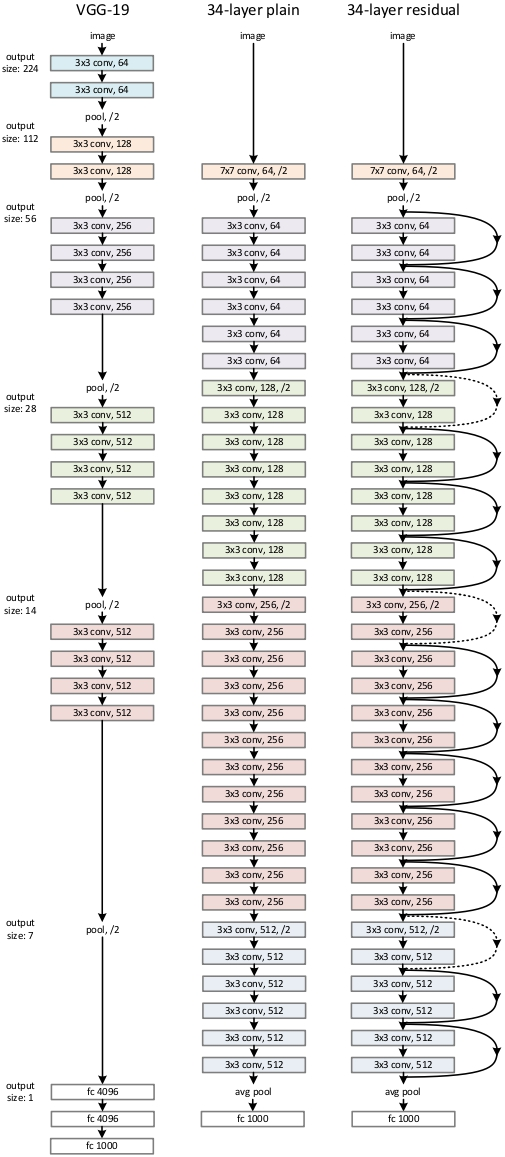

The ResNet architecture can be seen on the right of the figure above. Here is how to interpret it:
* every convolution is followed by a batch norm and a relu;
* "/2" means the height and width are halved (they are kept the same otherwise)
  * the padding is always $p = \frac{k-1}{2}$ (this is known as ["same" padding](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t), because it keeps the same size when the stride is 1)
  * the stride is 2 when there is a "/2", and 1 otherwise
* "$k \times k$ conv, $N$" represents a block of conv+batchnorm+relu, where $k \times k$ is the conv kernel size and $N$ is the number of output channels
* side arrows mean that the input is added before the relu at the output
  * bold arrows: output size equals input size, and input is added as is
  * dotted arrows: output height/width is half of the input, and double in features; in this case we downsample the input, passing it through a conv of kernel size 1x1 and stride 2;
* the "avg pool" here means a layer with input $(B, C, H, W)$ and output $(B, C, 1)$, where values over height and width dimensions are averaged out into a single value
* the "fc 1000" means a Linear layer with C input features and 1000 output features. Rather than hard-code 1000, we're going to have the number of output classes be a parameter of the model. You'll see that we've made an an argument to the ResNet class's `\_\_init\_\_` method.

Notice that, unlike an MLP, the dimensions of the input image are never hardcoded into this model.

### Step: Residual block

Start by implementing a residual block (i.e. 2x conv+batchnorm+relu, and a residual connection; the number of input and output channels can vary; whether the output size is the same or is halved can also vary).

In [ ]:
class ResidualBlock(Module):
    def __init__(self, in_feats, out_feats, downsample=False):
        pass

    def forward(self, x):
        pass

### Step: ResNet34

Implement now the ResNet34 architecture, according to the diagram, using the residual blocks from above.

In [ ]:
class ResNet34(Module):
    def __init__(self, output_size=1000):
        pass
  
    def forward(self, x):
        pass

Write a function that copies over the weights from the torchvision pretrained resnet34 into yours. The `model.state_dict()` and `model.load_state_dict()` methods will be of use.

In [ ]:
def copy_weights(my_model, torch_model):
    pass

Run the following cell to confirm that your model agrees with the torchvision model at the start.

In [ ]:
copy_weights(resnet34, torchvision_resnet34)
show_classes_probabilities(urls, resnet34)

### Training

### Step: Training your ResNet
That was too easy. Rather than importing someone else's magic parameters, let's actually train our ResNet. We're going to do so for a simpler image-recognition task, the CIFAR10 dataset. This is a dataset of 3x32x32 images that fall into 10 classes, so define a new model that just has 10 outputs. You can mostly follow along with this tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. Make sure your model is in training mode by calling model.train(). 

In [ ]:
import torchvision

cifar_train = torchvision.datasets.CIFAR10("~/mlab/datasets/cifar10_train",
                            transform= torchvision.transforms.Compose([
                                torchvision.transforms.PILToTensor(),
                                torchvision.transforms.ConvertImageDtype(torch.float)]),
                            download=True, 
                            train=True)

### Displaying what your ResNet has learned:

Run the cell below to print some CIFAR images and see how your model labelled them.

In [ ]:
cifar_test = torchvision.datasets.CIFAR10("~/mlab/datasets/cifar10_test",
                            transform= torchvision.transforms.Compose([
                                torchvision.transforms.PILToTensor(),
                                torchvision.transforms.ConvertImageDtype(torch.float)]),
                            download=True, 
                            train=False)

def eval_cifar(model, num_imgs=10):
    for_display = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((128, 128))])

    cifar_classes = { 0: "airplane",
                      1: "automobile",
                      2: "bird",
                      3: "cat",
                      4: "deer",
                      5: "dog",
                      6: "frog",
                      7: "horse",
                      8: "ship",
                      9: "truck"
                    }
    model.eval()
    with torch.no_grad():
        for i in range(num_imgs):
            x, y = cifar_test[i]
            outputs = model(x.unsqueeze(0))
            probs = torch.softmax(outputs, -1).flatten()
            sorted_probs, sorted_idxs = probs.sort(descending=True)
            sorted_probs = [p.item() for p in sorted_probs]
            sorted_classes = [cifar_classes[idx.item()] for idx in sorted_idxs]

            small_img = for_display(x.cpu())
            display(small_img)
            print(f"Actual class: {cifar_classes[y]}")
            k = 2
            print(
            *(f'{100*prob:05.2f}% | {label}' for prob, label in zip(sorted_probs[:k], sorted_classes[:k])),
            '...',
            *(f'{100*prob:08.5f}% | {label}' for prob, label in zip(sorted_probs[-k:], sorted_classes[-k:])),
            sep='\n',
            end='\n\n',
            )

eval_cifar(my_trained_model)

In [ ]:
import torch.nn as nn

# Nikola and Warren - TA Chris

## Readings

Introduction to Convolutions: https://www.youtube.com/watch?v=8rrHTtUzyZA

Residual Networks: https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035

The goal of this project is to familiarize ourselves with the fundamentals of deep learning engineering for computer vision and image recognition. We will reimplement from scratch a member of the ResNet family of vision models and apply our model to classify images into different categories.

We will start by loading an existing ResNet implementation (pretrained on ImageNet), and seeing what sorts of classificaton the model can output. Then, we will discuss and implement the basic blocks of computer vision architectures. After that, we will move to ResNet, and implement the architecture using our basic blocks. We will then use our model for classifying images.

# Prelude: image classifications from a pretrained ResNet

First, we load a pretrained ResNet model from the PyTorch vision repository.

In [ ]:
from torchvision import models
torchvision_resnet34 = models.resnet34(pretrained=True)
resnet34 = torchvision_resnet34
_ = resnet34.eval()

We will download images from the internet to feed into the model.

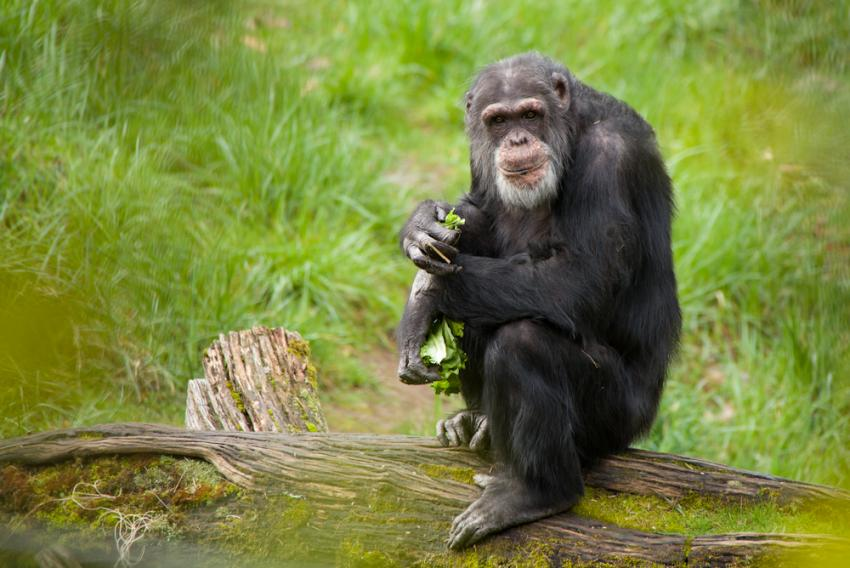

In [ ]:
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display

def load_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

url = "https://www.oregonzoo.org/sites/default/files/styles/article-full/public/animals/H_chimpanzee%20Jackson.jpg"
img = load_image(url)
img

The model expects a batch of images of shape `(num_images, num_channels=3, height, width)`, and outputs the [classfication logits](https://developers.google.com/machine-learning/glossary/#logits), which is of shape `(num_images, num_classes=1000)`.

In [ ]:
import torch
from torchvision import transforms

inputs = transforms.ToTensor()(img).unsqueeze_(0)
print(inputs.shape)
outputs = resnet34(inputs)
outputs = outputs
print(outputs.shape)

torch.Size([1, 3, 568, 850])
torch.Size([1, 1000])


We load the ImageNet class [labels](https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt).

In [ ]:
imagenet_labels_url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
response = requests.get(imagenet_labels_url)
imagenet_labels = eval(response.text)

We select a few random images from the internet, and check the classification results from the model, by looking at the most likely and least likely predicted classes.

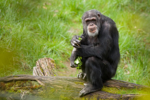

05.10% | chimpanzee, chimp, Pan troglodytes
01.48% | siamang, Hylobates syndactylus, Symphalangus syndactylus
01.32% | langur
...
00.00350% | pomegranate
00.00344% | rotisserie
00.00322% | admiral



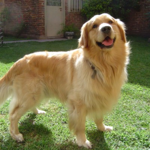

26.91% | golden retriever
05.63% | Great Pyrenees
04.29% | collie
...
00.00061% | gyromitra
00.00059% | stinkhorn, carrion fungus
00.00054% | bolete



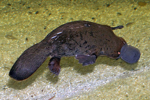

23.95% | platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus
18.00% | stingray
07.01% | electric ray, crampfish, numbfish, torpedo
...
00.00044% | maypole
00.00044% | crane
00.00035% | hand-held computer, hand-held microcomputer



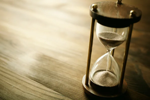

97.92% | hourglass
00.08% | beaker
00.07% | guillotine
...
00.00003% | sea slug, nudibranch
00.00003% | pickup, pickup truck
00.00003% | flatworm, platyhelminth



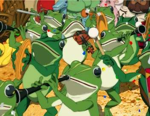

23.07% | comic book
17.85% | tray
13.01% | book jacket, dust cover, dust jacket, dust wrapper
...
00.00009% | puffer, pufferfish, blowfish, globefish
00.00007% | sports car, sport car
00.00004% | French loaf



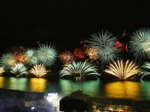

07.94% | seashore, coast, seacoast, sea-coast
07.28% | lakeside, lakeshore
04.36% | sandbar, sand bar
...
00.00210% | fig
00.00181% | cheeseburger
00.00138% | disk brake, disc brake



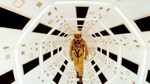

03.66% | maze, labyrinth
02.21% | vault
01.64% | dome
...
00.00203% | koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
00.00191% | jacamar
00.00137% | jellyfish



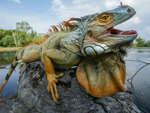

01.08% | common iguana, iguana, Iguana iguana
00.98% | bassinet
00.86% | mosquito net
...
00.00972% | police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria
00.00787% | gyromitra
00.00608% | slot, one-armed bandit



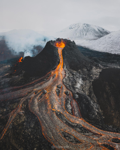

11.00% | volcano
02.99% | valley, vale
02.99% | sandbar, sand bar
...
00.00184% | bolete
00.00184% | tiger beetle
00.00102% | koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus



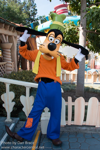

10.24% | picket fence, paling
07.19% | umbrella
02.42% | military uniform
...
00.00026% | red-breasted merganser, Mergus serrator
00.00022% | leafhopper
00.00021% | mud turtle



In [ ]:
urls = [
    "https://www.oregonzoo.org/sites/default/files/styles/article-full/public/animals/H_chimpanzee%20Jackson.jpg",
    "https://anipassion.com/ow_userfiles/plugins/animal/breed_image_56efffab3e169.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/f2/Platypus.jpg",
    "https://static5.depositphotos.com/1017950/406/i/600/depositphotos_4061551-stock-photo-hourglass.jpg",
    "https://img.nealis.fr/ptv/img/p/g/1465/1464424.jpg",
    "http://www.tudobembresil.com/wp-content/uploads/2015/11/nouvelancopacabana.jpg",
    "https://ychef.files.bbci.co.uk/976x549/p0639ffn.jpg",
    "https://www.thoughtco.com/thmb/Dk3bE4x1qKqrF6LBf2qzZM__LXE=/1333x1000/smart/filters:no_upscale()/iguana2-b554e81fc1834989a715b69d1eb18695.jpg",
    "https://i.redd.it/mbc00vg3kdr61.jpg",
    "https://static.wikia.nocookie.net/disneyfanon/images/a/af/Goofy_pulling_his_ears.jpg",
]

def show_classes_probabilities(urls, model, k=3):
    for url in urls:
        img = load_image(url)
        model.eval()

        inputs = transforms.ToTensor()(img).unsqueeze_(0)
        outputs = model(inputs)
        probs = torch.softmax(outputs, -1).flatten()
        sorted_probs, sorted_idxs = probs.sort(descending=True)
        sorted_probs = [p.item() for p in sorted_probs]
        sorted_classes = [imagenet_labels[idx.item()] for idx in sorted_idxs]

        small_img = img.copy()
        small_img.thumbnail((150, 150))
        display(small_img)
        print(
            *(f'{100*prob:05.2f}% | {label}' for prob, label in zip(sorted_probs[:k], sorted_classes[:k])),
            '...',
            *(f'{100*prob:08.5f}% | {label}' for prob, label in zip(sorted_probs[-k:], sorted_classes[-k:])),
            sep='\n',
            end='\n\n',
        )

show_classes_probabilities(urls, torchvision_resnet34)

### Step: adding images

Now it's your turn! Add a few urls below, and check what their classifications are.

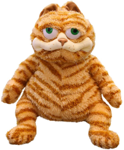

05.29% | wool, woolen, woollen
04.75% | teddy, teddy bear
02.31% | bib
...
00.00177% | African crocodile, Nile crocodile, Crocodylus niloticus
00.00150% | electric locomotive
00.00146% | tow truck, tow car, wrecker



In [ ]:
my_urls = [
    "https://m.media-amazon.com/images/I/61D0QLJU-hL._AC_SL1100_.jpg"
]

show_classes_probabilities(my_urls, torchvision_resnet34)

# Implementing ResNet building blocks

We now start implementing our own ResNet model.

## Operating on tensors: as_strided and einsum

To implement some of our building blocks, we will use the following functions:
* `torch.einsum`: implements summations over tensor indices using Einstein notation. You can read more about it here:
    * https://pytorch.org/docs/stable/generated/torch.einsum.html
    * https://ajcr.net/Basic-guide-to-einsum/
* `torch.as_strided`: PyTorch tensors data are physically stored as 1-d arrays, and the shape and stride abstractions describe a multidimensional indexing API into this data. The shape (or size) is an N-tuple describing the number of valid indices for each dimension. The stride is an N-tuple corersponding to how many cells to jump in the 1-d physical array when the index of each dimension is incremented. The function `.as_strided` can then be used to change the shape and stride of a tensor without changing the underlying data. This can be used to efficiently implement many operations on tensors. You can read more about it here:
    * https://pytorch.org/docs/stable/generated/torch.as_strided.html
    * https://jott.live/markdown/as_strided
    
We will start this section by familiarizing ourselves with these functions by reimplementing some matrix operations.

### Step: as_strided arguments

For each test case below, change the arguments `size` and `stride`, so that a call of `torch.as_strided(test_input_a, size=size, stride=stride)` matches the desired output.

In [ ]:
from collections import namedtuple

test_input_a = torch.tensor([[ 0,  1,  2,  3,  4],
                             [ 5,  6,  7,  8,  9],
                             [10, 11, 12, 13, 14],
                             [15, 16, 17, 18, 19]])

TestCase = namedtuple('TestCase', ['output', 'size', 'stride'])

test_cases = [
  TestCase(
    output=torch.tensor([0, 1, 2, 3]),
    size=(4,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[0, 1, 2],
                         [5, 6, 7]]),
    size=(2,3),
    stride=(5,1),
  ),
  TestCase(
    output=torch.tensor([[0, 0, 0],
                         [11, 11, 11]]),
    size=(2,3),
    stride=(11,0),
  ),
  TestCase(
    output=torch.tensor([0, 6, 12, 18]),
    size=(4,),
    stride=(6,),
  ),
  TestCase(
    output=torch.tensor([[[0, 1, 2],
                          [9, 10, 11]]]),
    size=(1,2,3),
    stride=(1,9,1),
  ),
  TestCase(
    output=torch.tensor([[[[0, 1],
                           [2, 3]],
                          [[4, 5],
                           [6, 7]]],
                         [[[12, 13],
                           [14, 15]],
                          [[16, 17],
                           [18, 19]]]]),
    size=(2,2,2,2),
    stride=(12,4,2,1),
  ),
]

In [ ]:
def is_equal_test(*, output, expected, test_name='Test'):
    successful = torch.allclose(expected.to(float), output.to(float))
    if successful:
        print(f'{test_name} passed!')
    else:
        print(f'{test_name} failed')
        print(f'Output:\n{output}')
        print(f'Expected:\n{expected}')

for i, (expected, size, stride) in enumerate(test_cases):
    output = torch.as_strided(test_input_a, size=size, stride=stride)
    is_equal_test(test_name=i, output=output, expected=expected)

0 passed!
1 passed!
2 passed!
3 passed!
4 passed!
5 passed!


### Step: as_strided trace

Implement a function that receives a square matrix (as a 2d tensor) and returns its [trace](https://en.wikipedia.org/wiki/Trace_(linear_algebra)) using `torch.as_strided` and `torch.sum`



In [ ]:
def strided_trace(a):
    return torch.sum(torch.as_strided(a, size = (a.size(dim=0),), stride = (1+a.size(dim=0),)))

In [ ]:
def einsum_trace(a):
    return torch.einsum('ii->', a)

a = torch.randn(10, 10)
assert torch.allclose(strided_trace(a), einsum_trace(a), rtol=1e-4, atol=1e-4)

### Step: as_strided matmul

Implement a function that receives two matrices (as 2d tensors) and returns their [multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication), using `torch.as_strided`, `torch.sum`, and elementwise multiplication.

In [ ]:
def strided_matmul(a, b):
    n = a.size(dim=0)
    m = a.size(dim=1)
    assert m == b.size(dim=0)
    o = b.size(dim=1)
    
    print(a.size())
    
    a = torch.as_strided(a, size = (n,m,o), stride= (m,1,0))
    b = torch.as_strided(b, size = (n,m,o), stride= (0,o,1))
    
    return torch.sum(a * b, dim = 1)
    
    

In [ ]:
def einsum_matmul(a, b):
    return torch.einsum('ik,kj->ij', a, b)

a = torch.randn(10, 5)
b = torch.randn(5, 15)
assert torch.allclose(strided_matmul(a, b), einsum_matmul(a, b), rtol=1e-4, atol=1e-4)

torch.Size([10, 5])


## Convolutions and pooling

Convolutions are one of the fundamental operations of signal processing. It can be interpreted as a sliding window (a "weight") that goes over all positions of the input and outputs a weighted sum of the values of the region (i.e. the dot product of the weight and the region). Watch this 30-second video: https://www.youtube.com/watch?v=ulKbLD6BRJA

We're going to begin by implementing 1d convolutions without "padding" (when the weight sticks off one side of the input). This means, unlike in the video, the output of the convolution will be a little smaller than the input. See the below image for examples:

<img src=../../.images/1d_conv.jpeg width=800>

We will also implement 2d convolution, in which the weight slides around on the input in 2d, producing one weighted sum in the output for each location it occupies:

<img src=../../.images/2d_conv.png width=800>

A 1-d Convolution can be written as:

$$\operatorname{conv1d}(input, weights)[b, c_o, i] = \sum_{c_i = 0}^{C_i} \sum_{di = 0}^{k-1} weights[c_o, c_i, di] \cdot input[b, c_i, i+di]$$

A 2-d Convolution can be written as:
$$\operatorname{conv2d}(input, weights)[b, c_o, i, j] = \sum_{c_i = 0}^{C_i} \sum_{di = 0}^{k_h-1}\sum_{dj = 0}^{k_w-1} weights[c_o, c_i, di, dj] \cdot input[b, c_i, i+di, j+dj]$$


Clarification on notation: the brackets on the LHS are indices into the output of the function, which (as you can see from the number of indices) is a rank-4 tensor: batch size, num of channels, width, height.

One way to think about convolutions is that convolutions are the linear translation invariant functions. That is, if F is a function, and the following holds:
* $F(x + y) = F(x) + F(y)$
* $F(T(x)) = T(F(x))$ (where $T$ corresponds to shifting the input)

Then $F$ can be written as a convolution.

### Step: conv1d arguments

To get familiarity with `conv1d`, replace the indicated variables to pass the tests below.

In [ ]:
from torch.nn.functional import conv1d as torch_conv1d
from torch.nn.functional import conv2d as torch_conv2d

Replace `weights` to pass the test.

In [ ]:
input = torch.tensor([[[1, 2, 3, 4]]])
weights = torch.tensor([[[1, 3]]])
output = torch_conv1d(input, weights)
expected = torch.tensor([7.0, 11.0, 15.0])
is_equal_test(output=output, expected=expected)

Test passed!


Replace `input` to pass the test.

In [ ]:
input = torch.tensor([[[98, 12, -7, -3, -1, -1, 1, 1]]])
weights = torch.tensor([[[2, 0, -2]]])
output = torch_conv1d(input, weights)
expected = torch.tensor([[[210, 30, -12, -4, -4, -4]]])
is_equal_test(output=output, expected=expected)

Test passed!


Replace `weights` to pass the test.

In [ ]:
input = torch.tensor([[[1, 2, 3],
                       [4, 5, 6]],
                      [[1, 1, 1],
                       [2, 3, 2]]])
weights = torch.tensor([[[1], [2]]]) 
output = torch_conv1d(input, weights)
expected = torch.tensor([[[9, 12, 15]],
                         [[5, 7, 5]]])
is_equal_test(output=output, expected=expected)

Test passed!


### Step: conv1d

Implement 1d convolutions using `torch.as_strided` and `torch.einsum`.

In [ ]:
# x : (batchsize, in_channels, seqlen), weights : (out_channels, in_channels, weight_width)

def conv1d_minimal(x, weights):
    b, c, l = x.size()
    o = weights.size(dim=0)
    k = weights.size(dim=-1)
    x = torch.as_strided(x, size=(b, c, k, l-k+1), stride=(c*l,l,1, 1))

    return torch.einsum("b c k l, o c k -> b o l", x, weights)
    # (batchsize, out_channels, seqlen - weight_width + 1)

In [ ]:
def test_conv1d_minimal(my_conv, n_tests=10):
    import numpy as np
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        weight_size = np.random.randint(1, 10)

        x = torch.randn((b, ci, h))
        weights = torch.randn((co, ci, weight_size))

        my_output = my_conv(x, weights)

        torch_output = torch.conv1d(
            x,
            weights,
            stride=1,
            padding=0,
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv1d (minimal) test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...")
            return
        print(f"Test {i} passed!")
    print('All tests passed!')

test_conv1d_minimal(conv1d_minimal)

Test 0 passed!
Test 1 passed!
Test 2 passed!
Test 3 passed!
Test 4 passed!
Test 5 passed!
Test 6 passed!
Test 7 passed!
Test 8 passed!
Test 9 passed!
All tests passed!


### Step: conv2d

Implement 2d convolutions (with minimal arguments). Use `torch.as_strided` and `torch.einsum`.

In [ ]:
# x : (batchsize, in_channels, height, width), weights : (out_channels, in_channels, weight_height, weight_width)

def conv2d_minimal(x, weights):
    b, c, h, w = x.size()
    o = weights.size(dim=0)
    k_h = weights.size(dim=-2)
    k_w = weights.size(dim=-1)
    x = torch.as_strided(x, size=(b, c, k_h, k_w, h-k_h+1, w-k_w+1), stride=(c*h*w, h*w, w, 1, w, 1))

    return torch.einsum("b c i j h w, o c i j -> b o h w", x, weights)
    # (batchsize, out_channels, seqlen - weight_width + 1)

In [ ]:
def test_conv2d_minimal(my_conv, n_tests = 10):
    import numpy as np
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        weight_size = tuple(np.random.randint(1, 10, size=(2,)))

        x = torch.randn((b, ci, h, w))
        weights = torch.randn((co, ci, *weight_size))

        my_output = my_conv(
            x,
            weights
        )

        torch_output = torch.conv2d(
            x,
            weights
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv2d test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...,")
            return
        print(f"Test {i} passed!")

    print('All tests passed!')

test_conv2d_minimal(conv2d_minimal)

Test 0 passed!
Test 1 passed!
Test 2 passed!
Test 3 passed!
Test 4 passed!
Test 5 passed!
Test 6 passed!
Test 7 passed!
Test 8 passed!
Test 9 passed!
All tests passed!


### Step: stride and padding

Convolutions generally take a few extra arguments, such as:
* `stride`: how many positions to increment in the input for each position increment in the output. Useful for downsampling the input.
* `padding`: pads the input with $p$ zeroes on each side before applying the convolution. Useful for controlling the output size.

Add `stride` and `padding` parameters to your implementations of `conv1d`, `conv2d`.

In [ ]:
# x : (batchsize, in_channels, seq_len), 
# weights : (out_channels, in_channels, weight_width), 
# stride: int
# padding: int
def conv1d(x, weights, stride=1, padding=0):
    b, c, l = x.size()
    o = weights.size(dim=0)
    k = weights.size(dim=-1)
    x_padded = torch.zeros(b,c,l+2*padding)
    x_padded[:,:,padding:-padding] = x
    x_padded = torch.as_strided(x_padded, size=(b, c, k, math.ceil((l-k+1+2*padding)/stride)), stride=(c*(l+2*padding),l+2*padding,1, stride))

    return torch.einsum("b c k l, o c k -> b o l", x_padded, weights)

# x : (batchsize, in_channels, height, width), 
# weights : (out_channels, in_channels, weight_height, weight_width), 
# stride: int or tuple(int, int)
# padding: int or tuple(int, int)
def conv2d(x, weights, stride=1, padding=0):
    b, c, h, w = x.size()
    assert(c == weights.size(dim=1))
    o = weights.size(dim=0)
    k_h = weights.size(dim=-2)
    k_w = weights.size(dim=-1)
    if type(padding) == int:
        padding = (padding, padding)
    if type(stride)==int:
        stride=(stride,stride)
    p_h, p_w = padding
    s_h, s_w = stride
    h_padded = h + 2*p_h
    w_padded = w + 2*p_w
    x_padded = torch.zeros(b,c,h+2*p_h, w+2*p_w)
    x_padded[:,:,p_h:h_padded-p_h,p_w:w_padded-p_w] = x
    x_padded = torch.as_strided(x_padded, 
        size=(b, c, k_h, k_w, math.ceil((h_padded-k_h+1)/s_h), math.ceil((w_padded-k_w+1)/s_w)), 
        stride=(c*h_padded*w_padded, h_padded*w_padded, w_padded, 1, w_padded*s_h, s_w)
    )
    'bcxyij,ocij->boxy'
    return torch.einsum("b c i j h w, o c i j -> b o h w", x_padded, weights)

In [ ]:
#@title conv2d fuzz tests { form-width:"200px" }


def test_conv1d(my_conv, n_tests = 10):
    import numpy as np

    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        stride = np.random.randint(1, 5)
        padding = np.random.randint(1, 5)
        weight_size = np.random.randint(1, 10)

        x = torch.randn((b, ci, h))
        weights = torch.randn((co, ci, weight_size))

        my_output = my_conv(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        torch_output = torch.conv1d(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv1d test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...")
            return
        print(f"Test {i} passed!")
    print('All tests passed!')

test_conv1d(conv1d)

def test_conv2d(my_conv, n_tests = 10):
    import numpy as np
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)

        stride = tuple(np.random.randint(1, 5, size=(2,)))
        padding = tuple(np.random.randint(1, 5, size=(2,)))
        weight_size = tuple(np.random.randint(1, 10, size=(2,)))

        x = torch.randn((b, ci, h, w))
        weights = torch.randn((co, ci, *weight_size))
        bias = torch.randn((co,))

        my_output = my_conv(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        torch_output = torch.conv2d(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv2d test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...,")
            return
        print(f"Test {i} passed!")

    print('All tests passed!')

test_conv2d(conv2d)



Test 0 passed!
Test 1 passed!
Test 2 passed!
Test 3 passed!
Test 4 passed!
Test 5 passed!
Test 6 passed!
Test 7 passed!
Test 8 passed!
Test 9 passed!
All tests passed!
Test 0 passed!
Test 1 passed!
Test 2 passed!
Test 3 passed!
Test 4 passed!
Test 5 passed!
Test 6 passed!
Test 7 passed!
Test 8 passed!
Test 9 passed!
All tests passed!


### Step: maxpool2d

Poolings have the same format as convolutions - only that instead of outputting a weighted sum, max poolings output the maximum value of the window, and average poolings output the average.

Implement 2d max pooling using `torch.as_strided` and `torch.amax`.


In [ ]:
# x : (batchsize, in_channels, height, width), 
# weight_size : int or tuple(int, int)
# stride: None or int or tuple(int, int) (assume stride=weight_size if None)
# padding: int or tuple(int, int)

def maxpool2d(x, weight_size, stride=None, padding=0):
    b, c, h, w = x.size()
    
    if type(padding) == int:
        padding = (padding, padding)
    if stride is None:
        stride = weight_size
    if type(stride)==int:
        stride=(stride,stride)
    if type(weight_size) == int:
        weight_size = (weight_size, weight_size)
        
    p_h, p_w = padding
    s_h, s_w = stride
    k_h, k_w = weight_size
    #print(weight_size)
    h_padded = h + 2*p_h
    w_padded = w + 2*p_w
    
    x_padded = torch.ones(b,c,h+2*p_h, w+2*p_w) * (-torch.inf)
    #print(x_padded.size(), x.size(), padding)
    x_padded[:,:,p_h:h_padded-p_h,p_w:w_padded-p_w] = x
    x_padded = torch.as_strided(x_padded, 
        size=(b, c, k_h, k_w, math.ceil((h_padded-k_h+1)/s_h), math.ceil((w_padded-k_w+1)/s_w)), 
        stride=(c*h_padded*w_padded, h_padded*w_padded, w_padded, 1, w_padded*s_h, s_w)
    )
    #print(x_padded.size())
    #print(weight_size)
    ret = torch.amax(x_padded, dim=(2, 3))
    #print(f'size: {x.size()}, weight: {weight_size}, stride: {stride}, pad: {padding}')
    #print(ret.size())
    #print()
    return ret


In [ ]:
#@title maxpool2d fuzz tests { form-width: "200px" }

from torch.nn.functional import max_pool2d as torch_maxpool2d

# Fuzz test
def test_maxpool(my_maxpool2d, n_tests = 100):
    import numpy as np
    
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)

        none_stride = bool(np.random.randint(2))
        if none_stride:
            stride = None
        else:
            stride = tuple(np.random.randint(1, 5, size=(2,)))
        weight_size = tuple(np.random.randint(1, 10, size=(2,)))
        kH, kW = weight_size
        padding = np.random.randint(0, 1 + kH//2), np.random.randint(0, 1 + kW//2)

        x = torch.randn((b, ci, h, w))

        my_output = my_maxpool2d(
            x,
            weight_size,
            stride=stride,
            padding=padding,
        )

        torch_output = torch_maxpool2d(
            x,
            weight_size,
            stride=stride,
            padding=padding,
        )
        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print('A test failed!')
            '''
            print('input:')
            print(x)
            print('----------')
            print('output:')
            print(my_output)
            print('expected:')
            print('----------')
            print(torch_output)
            '''
            #print("bools")
            #print(my_output == torch_output)
            return
        else:
            print("test " + str(i))

    print('All tests passed!')

test_maxpool(maxpool2d)


test 0
test 1
test 2
test 3
test 4
test 5
test 6
test 7
test 8
test 9
test 10
test 11
test 12
test 13
test 14
test 15
test 16
test 17
test 18
test 19
test 20
test 21
test 22
test 23
test 24
test 25
test 26
test 27
test 28
test 29
test 30
test 31
test 32
test 33
test 34
test 35
test 36
test 37
test 38
test 39
test 40
test 41
test 42
test 43
test 44
test 45
test 46
test 47
test 48
test 49
test 50
test 51
test 52
test 53
test 54
test 55
test 56
test 57
test 58
test 59
test 60
test 61
test 62
test 63
test 64
test 65
test 66
test 67
test 68
test 69
test 70
test 71
test 72
test 73
test 74
test 75
test 76
test 77
test 78
test 79
test 80
test 81
test 82
test 83
test 84
test 85
test 86
test 87
test 88
test 89
test 90
test 91
test 92
test 93
test 94
test 95
test 96
test 97
test 98
test 99
All tests passed!


### Step: Conv2d, MaxPool2d Modules

Implement now Conv2d and MaxPool2d classes, each inheriting `nn.Module`. When you inherit `nn.Module`, your class should define:

- `__init__()`: the constructor. At the start of your constructor, remember to call the constructor of `nn.Module` with `super().__init__()`.
- `forward()`: when your module as invoked as if it were a function with the expression `module(x)`, this results in a call to `module.forward(x)`.  

If you need more info, read our doc on `nn.Module` subclasses [here](https://docs.google.com/document/d/1PYW_lW_-jXpN394S8LtPqivSB91HjAwQi6_iDtmpwXg/edit?usp=sharing)

Crucially, your conv weight should be wrapped in a `torch.nn.Parameter()`. When a `torch.nn.Parameter()` is assigned as an attribute of a `nn.Module`, it will get automatically registered as a learnable parameter, meaning that `model.parameters()` will include it. Additionally, by default `Parameters` keep track of their gradients, while `Tensors` by default do not.

For initializing the values of the Conv2d parameters, read [this](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79)

Do Kaiming initialization, as described in the above. The fan-in should be the number of incoming connections that a specific neuron in the conv layer has: `in_channels * weight_width * weight_height`

In [ ]:
from torch.nn import Module, Parameter

class Conv2d(Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        weight_size,
        stride=1,
        padding=0,
    ):
        super().__init__()
        if type(weight_size)==int:
            weight_size = (weight_size, weight_size)
        fan_in = in_channels * weight_size[0]*weight_size[1]
        self.weight = nn.Parameter(torch.randn(out_channels,in_channels, weight_size[0], weight_size[1]) * math.sqrt(2/fan_in))
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        return conv2d(x, self.weight, self.stride, self.padding)
        
# x : (batchsize, in_channels, height, width), 
# weight_size : int or tuple(int, int)
# stride: None or int or tuple(int, int) (assume stride=weight_size if None)
# padding: int or tuple(int, int)

def maxpool2d(x, weight_size, stride=None, padding=0):
    b, c, h, w = x.size()
    
    if type(padding) == int:
        padding = (padding, padding)
    if stride is None:
        stride = weight_size
    if type(stride)==int:
        stride=(stride,stride)
    if type(weight_size) == int:
        weight_size = (weight_size, weight_size)
        
    p_h, p_w = padding
    s_h, s_w = stride
    k_h, k_w = weight_size
    #print(weight_size)
    h_padded = h + 2*p_h
    w_padded = w + 2*p_w
    
    x_padded = torch.ones(b,c,h+2*p_h, w+2*p_w) * (-torch.inf)
    #print(x_padded.size(), x.size(), padding)
    x_padded[:,:,p_h:h_padded-p_h,p_w:w_padded-p_w] = x
    x_padded = torch.as_strided(x_padded, 
        size=(b, c, k_h, k_w, math.ceil((h_padded-k_h+1)/s_h), math.ceil((w_padded-k_w+1)/s_w)), 
        stride=(c*h_padded*w_padded, h_padded*w_padded, w_padded, 1, w_padded*s_h, s_w)
    )
    #print(x_padded.size())
    #print(weight_size)
    ret = torch.amax(x_padded, dim=(2, 3))
    #print(f'size: {x.size()}, weight: {weight_size}, stride: {stride}, pad: {padding}')
    #print(ret.size())
    #print()
    return ret

class MaxPool2d(Module):
    def __init__(
        self,
        weight_size,
        stride=None,
        padding=1,
    ):
        super().__init__()
        self.weight_size = weight_size
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        return maxpool2d(x, self.weight_size, self.stride, self.padding)


## Batch Normalization

One intuition for batch norm is that we don't want the "units"/scale of our input features to matter, because this might distort how they get optimized relative to each other. Thus we would like to make each input feature have mean 0 and variance 1 across the population. To approximate this, we normalize each feature within its batch. We also keep a running mean/variance estimation during training that we use during testing (for more accuracy than the batch stats).

In practice, we normalize entire channels at once, rather than single pixels. This means normalizing each pixel by the mean/variance of all the pixels within that channel, across height, width, and batch.

Read more about batch normalization [here](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739), and look at the diagrams of batchnorm during training/inference for more specifics, which you'll need for your implementation.

Documentation for batchnorm: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html

### Step: BatchNorm2d

Implement a BatchNorm2d module.

In [ ]:
class BatchNorm2d(Module):
    def __init__(
        self,
        num_features,
        eps=1e-5,
        momentum=0.1,
    ):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(num_features))
        self.bias = nn.Parameter(torch.zeros(num_features))

        self.momentum = momentum
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        self.register_buffer('num_batches_tracked', torch.tensor(0))

    def forward(self, x):
        # x is a Tensor, shape=(batchsize, num_features,)
        if self.training:
            mean = torch.mean(x, dim=(0, 2, 3))
            var = torch.var(x, dim=(0, 2, 3))
            self.running_mean = self.momentum*self.running_mean + (1-self.momentum)*mean
            self.running_var = self.momentum*self.running_var + (1-self.momentum)*var

        if not self.training:
            mean = self.running_mean
            var = self.running_var
        
        rs = lambda u : u.reshape(1, -1, 1, 1)
        return (x - rs(mean))/torch.sqrt(rs(var)+self.eps)*rs(self.weight) + rs(self.bias)

# Assembling your ResNet

The ResNet has many features typical of vision architectures: blocks of conv + batchnorm + relu, a decreasing width/height paired with an increasing number of channels, and a linear layer at the end that produces logits. It set itself apart from other models at the time by incorporating residual blocks, which add the input to the output of the conv/batchnorm before the relu. These improved loss for large models, as it's easier to propagate signals over many layers of identity mapping + noise, than to propagate signals over many layers of noise.


[ResNet paper](https://arxiv.org/abs/1512.03385)


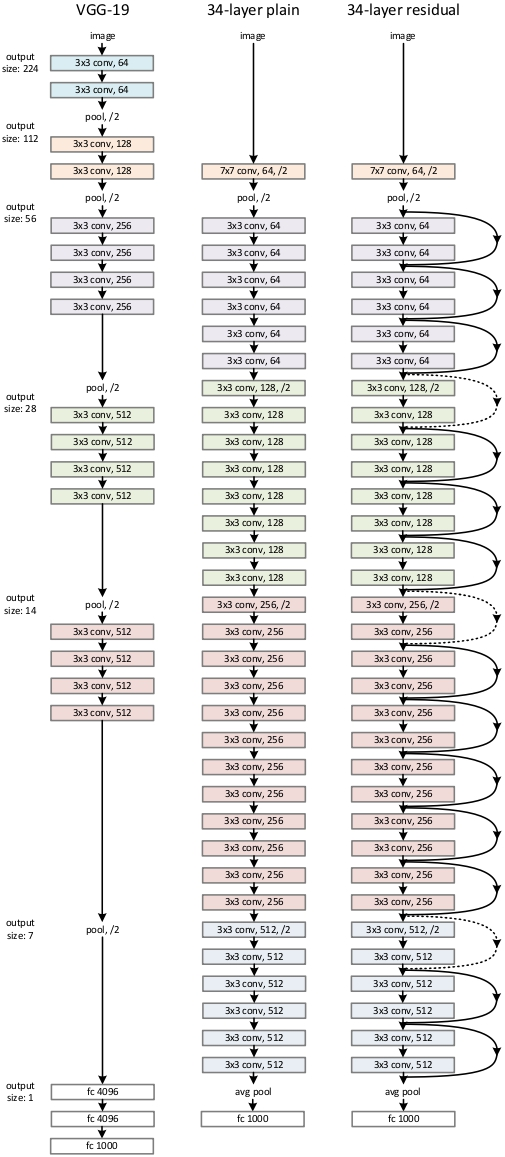

The ResNet architecture can be seen on the right of the figure above. Here is how to interpret it:
* every convolution is followed by a batch norm and a relu;
* "/2" means the height and width are halved (they are kept the same otherwise)
  * the padding is always $p = \frac{k-1}{2}$ (this is known as ["same" padding](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t), because it keeps the same size when the stride is 1)
  * the stride is 2 when there is a "/2", and 1 otherwise
* "$k \times k$ conv, $N$" represents a block of conv+batchnorm+relu, where $k \times k$ is the conv weight size and $N$ is the number of output channels
* side arrows mean that the input is added before the relu at the output
  * bold arrows: output size equals input size, and input is added as is
  * dotted arrows: output height/width is half of the input, and double in features; in this case we downsample the input, passing it through a conv of weight size 1x1 and stride 2;
* the "avg pool" here means a layer with input $(B, C, H, W)$ and output $(B, C, 1)$, where values over height and width dimensions are averaged out into a single value
* the "fc 1000" means a Linear layer with C input features and 1000 output features. Rather than hard-code 1000, we're going to have the number of output classes be a parameter of the model. You'll see that we've made an an argument to the ResNet class's `\_\_init\_\_` method.

Notice that, unlike an MLP, the dimensions of the input image are never hardcoded into this model.

### Step: Residual block

## Start by implementing a residual block (i.e. 2x conv+batchnorm+relu, and a residual connection; the number of input and output channels can vary; whether the output size is the same or is halved can also vary).

In [ ]:
def relu(x):
    x[x<0] = 0
    return x

class ReLu(Module):
    def forward(self, x):
        x[x<0] = 0
        return x

def AveragePool(x):
    return torch.mean(x, dim=(2,3))

class Linear(Module):
    def __init__(self, in_feats, out_feats, downsample=False):
        super().__init__()
        self.weight = nn.Parameter(torch.randn( out_feats, in_feats) * math.sqrt(1/in_feats))
        self.bias = nn.Parameter(torch.randn(out_feats))
        
    def forward(self, x):
        return torch.einsum("...j, kj -> ...k" ,x, self.weight) + self.bias

class ResidualBlock(Module):
    def __init__(self, in_feats, out_feats, downsample=False):
        super().__init__()
        if downsample:
            self.stride_1 = 2
        else:
            self.stride_1 = 1
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.conv1 = Conv2d(in_feats, out_feats, stride = self.stride_1, weight_size = (3,3), padding =1)
        self.bn1 = BatchNorm2d(out_feats)
        self.conv2 = Conv2d(out_feats, out_feats, stride = 1, weight_size = (3,3), padding =1)
        self.bn2 = BatchNorm2d(out_feats)
        
        self.relu = ReLu()
        
        self.ds = downsample
        if downsample:
            self.downsample = torch.nn.Sequential(
                Conv2d(in_feats, out_feats, stride=2, weight_size=1),
                BatchNorm2d(out_feats)
            )
        else:
            self.stride_1 = 1
        
    def forward(self, x):
        x_new = self.conv1(x)
        x_new = self.bn1(x_new)
        x_new = self.relu(x_new)
        x_new = self.conv2(x_new)
        x_new = self.bn2(x_new)
        # Residual layer
        if self.ds:
            x_new = x_new + self.downsample(x)
        else:
            x_new = x_new + x
        
        x_new = relu(x_new)
        
        return x_new
        

### Step: ResNet34

Implement now the ResNet34 architecture, according to the diagram, using the residual blocks from above.

In [ ]:
class ResNet34(Module):
    def __init__(self, output_size=1000):
        super().__init__()
        self.output_size = output_size
        self.conv1 = Conv2d(3, 64, weight_size = 7, stride = 2, padding = 3)
        self.bn1 = BatchNorm2d(64)
        self.maxpool = MaxPool2d(3, stride=2)
        self.layer1 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64))

            #green
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, downsample = True),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128))

        self.layer3 = nn.Sequential(
            #red
            ResidualBlock(128, 256, downsample = True),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256))
        self.layer4 = nn.Sequential(
            #blue
            ResidualBlock(256, 512, downsample = True),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512)
        )
        self.fc = Linear(512, self.output_size)
        
            
    def forward(self, x):
        x_new = self.conv1(x)
        x_new = self.bn1(x_new)
        x_new = self.maxpool(x_new)
        x_new = self.layer1(x_new)
        x_new = self.layer2(x_new)
        x_new = self.layer3(x_new)
        x_new = self.layer4(x_new)
        x_new = AveragePool(x_new)
        x_new = self.fc(x_new)
        return x_new

Write a function that copies over the weights from the torchvision pretrained resnet34 into yours. The `model.state_dict()` and `model.load_state_dict()` methods will be of use.

In [ ]:
def copy_weights(my_model, torch_model):
    my_model.load_state_dict(torch_model.state_dict()) 

In [ ]:

jank_res = ResNet34()
k = jank_res.state_dict().keys()
print(len(k))
print()
r = resnet34.state_dict().keys()
print(len(r))
for a, b in itertools.zip_longest(k, r):
    print (str(a) + "  ||  " + str(b))

    print ("FALSE############\n" if not jank_res.state_dict()[a].size()  ==resnet34.state_dict()[b].size() else "", str(jank_res.state_dict()[a].size() )+ "  ||  " + str(resnet34.state_dict()[b].size()))


218

218
conv1.weight  ||  conv1.weight
 torch.Size([64, 3, 7, 7])  ||  torch.Size([64, 3, 7, 7])
bn1.weight  ||  bn1.weight
 torch.Size([64])  ||  torch.Size([64])
bn1.bias  ||  bn1.bias
 torch.Size([64])  ||  torch.Size([64])
bn1.running_mean  ||  bn1.running_mean
 torch.Size([64])  ||  torch.Size([64])
bn1.running_var  ||  bn1.running_var
 torch.Size([64])  ||  torch.Size([64])
bn1.num_batches_tracked  ||  bn1.num_batches_tracked
 torch.Size([])  ||  torch.Size([])
layer1.0.conv1.weight  ||  layer1.0.conv1.weight
 torch.Size([64, 64, 3, 3])  ||  torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight  ||  layer1.0.bn1.weight
 torch.Size([64])  ||  torch.Size([64])
layer1.0.bn1.bias  ||  layer1.0.bn1.bias
 torch.Size([64])  ||  torch.Size([64])
layer1.0.bn1.running_mean  ||  layer1.0.bn1.running_mean
 torch.Size([64])  ||  torch.Size([64])
layer1.0.bn1.running_var  ||  layer1.0.bn1.running_var
 torch.Size([64])  ||  torch.Size([64])
layer1.0.bn1.num_batches_tracked  ||  layer1.0.bn1.num_batch

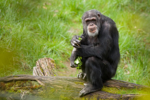

05.81% | chimpanzee, chimp, Pan troglodytes
02.60% | langur
02.18% | siamang, Hylobates syndactylus, Symphalangus syndactylus
...
00.00250% | cheeseburger
00.00232% | shoe shop, shoe-shop, shoe store
00.00230% | moving van



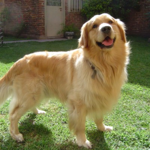

30.00% | golden retriever
06.93% | Great Pyrenees
05.66% | collie
...
00.00050% | admiral
00.00050% | bolete
00.00046% | stinkhorn, carrion fungus



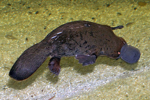

20.86% | platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus
20.30% | stingray
10.68% | electric ray, crampfish, numbfish, torpedo
...
00.00025% | triumphal arch
00.00025% | totem pole
00.00025% | aircraft carrier, carrier, flattop, attack aircraft carrier



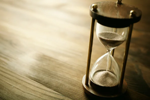

98.17% | hourglass
00.06% | guillotine
00.05% | beaker
...
00.00002% | sea slug, nudibranch
00.00002% | flatworm, platyhelminth
00.00002% | pickup, pickup truck



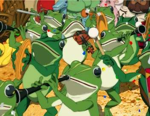

27.82% | tray
09.37% | comic book
08.94% | book jacket, dust cover, dust jacket, dust wrapper
...
00.00011% | European fire salamander, Salamandra salamandra
00.00007% | sports car, sport car
00.00006% | French loaf



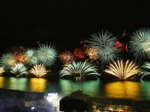

06.12% | seashore, coast, seacoast, sea-coast
05.14% | lakeside, lakeshore
03.43% | sandbar, sand bar
...
00.00231% | pizza, pizza pie
00.00229% | bell pepper
00.00155% | disk brake, disc brake



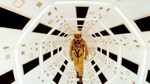

02.18% | maze, labyrinth
02.04% | vault
01.50% | wall clock
...
00.00193% | indri, indris, Indri indri, Indri brevicaudatus
00.00166% | flatworm, platyhelminth
00.00117% | jellyfish



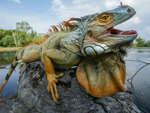

01.13% | common iguana, iguana, Iguana iguana
01.00% | starfish, sea star
00.94% | mosquito net
...
00.00783% | electric locomotive
00.00710% | gyromitra
00.00467% | slot, one-armed bandit



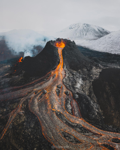

09.92% | volcano
03.02% | alp
02.69% | sandbar, sand bar
...
00.00195% | cheeseburger
00.00193% | espresso maker
00.00099% | koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus



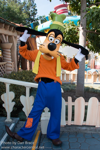

16.20% | picket fence, paling
04.18% | crib, cot
03.57% | umbrella
...
00.00024% | mud turtle
00.00019% | buckeye, horse chestnut, conker
00.00019% | red-breasted merganser, Mergus serrator



In [ ]:
# x = resnet34.state_dict()['conv1.weight']
# print(x.size(), x)
copy_weights(jank_res, resnet34)
show_classes_probabilities(urls, jank_res)


Run the following cell to confirm that your model agrees with the torchvision model at the start.

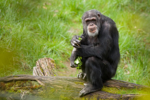

05.81% | chimpanzee, chimp, Pan troglodytes
02.60% | langur
02.18% | siamang, Hylobates syndactylus, Symphalangus syndactylus
...
00.00250% | cheeseburger
00.00232% | shoe shop, shoe-shop, shoe store
00.00230% | moving van



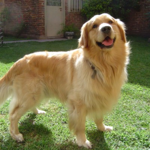

30.00% | golden retriever
06.93% | Great Pyrenees
05.66% | collie
...
00.00050% | admiral
00.00050% | bolete
00.00046% | stinkhorn, carrion fungus



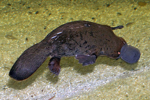

20.86% | platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus
20.30% | stingray
10.68% | electric ray, crampfish, numbfish, torpedo
...
00.00025% | triumphal arch
00.00025% | totem pole
00.00025% | aircraft carrier, carrier, flattop, attack aircraft carrier



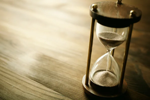

98.17% | hourglass
00.06% | guillotine
00.05% | beaker
...
00.00002% | sea slug, nudibranch
00.00002% | flatworm, platyhelminth
00.00002% | pickup, pickup truck



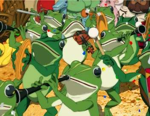

27.82% | tray
09.37% | comic book
08.94% | book jacket, dust cover, dust jacket, dust wrapper
...
00.00011% | European fire salamander, Salamandra salamandra
00.00007% | sports car, sport car
00.00006% | French loaf



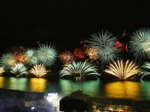

06.12% | seashore, coast, seacoast, sea-coast
05.14% | lakeside, lakeshore
03.43% | sandbar, sand bar
...
00.00231% | pizza, pizza pie
00.00229% | bell pepper
00.00155% | disk brake, disc brake



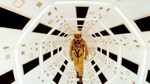

02.18% | maze, labyrinth
02.04% | vault
01.50% | wall clock
...
00.00193% | indri, indris, Indri indri, Indri brevicaudatus
00.00166% | flatworm, platyhelminth
00.00117% | jellyfish



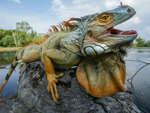

01.13% | common iguana, iguana, Iguana iguana
01.00% | starfish, sea star
00.94% | mosquito net
...
00.00783% | electric locomotive
00.00710% | gyromitra
00.00467% | slot, one-armed bandit



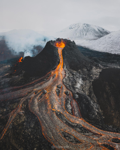

09.92% | volcano
03.02% | alp
02.69% | sandbar, sand bar
...
00.00195% | cheeseburger
00.00193% | espresso maker
00.00099% | koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus



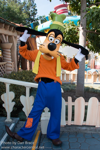

16.20% | picket fence, paling
04.18% | crib, cot
03.57% | umbrella
...
00.00024% | mud turtle
00.00019% | buckeye, horse chestnut, conker
00.00019% | red-breasted merganser, Mergus serrator



In [ ]:


copy_weights(resnet34, torchvision_resnet34)

resnet34_backup = resnet34

jank_res = ResNet34()
copy_weights(jank_res, resnet34)
show_classes_probabilities(urls, jank_res)


### Training

### Step: Training your ResNet
That was too easy. Rather than importing someone else's magic parameters, let's actually train our ResNet. We're going to do so for a simpler image-recognition task, the CIFAR10 dataset. This is a dataset of 3x32x32 images that fall into 10 classes, so define a new model that just has 10 outputs. You can mostly follow along with this tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. Make sure your model is in training mode by calling model.train(). 

In [ ]:
import torchvision

cifar_train = torchvision.datasets.CIFAR10("~/mlab/datasets/cifar10_train",
                            transform= torchvision.transforms.Compose([
                                torchvision.transforms.PILToTensor(),
                                torchvision.transforms.ConvertImageDtype(torch.float)]),
                            download=True, 
                            train=True)

Files already downloaded and verified


In [ ]:
jank_cifar = ResNet34(10)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

#trainset = cifar_train
trainset = torchvision.datasets.CIFAR10(root="~/mlab/datasets/cifar10_train", train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(jank_cifar.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = jank_cifar(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        if i > 2000:
            break
print('Finished Training')

Files already downloaded and verified
[1,    20] loss: 0.024
[1,    40] loss: 0.023
[1,    60] loss: 0.026
[1,    80] loss: 0.023
[1,   100] loss: 0.026
[1,   120] loss: 0.023
[1,   140] loss: 0.024
[1,   160] loss: 0.021
[1,   180] loss: 0.023
[1,   200] loss: 0.023
[1,   220] loss: 0.025
[1,   240] loss: 0.024
[1,   260] loss: 0.025
[1,   280] loss: 0.026
[1,   300] loss: 0.027
[1,   320] loss: 0.025
[1,   340] loss: 0.025
[1,   360] loss: 0.024
[1,   380] loss: 0.025
[1,   400] loss: 0.024
[1,   420] loss: 0.024
[1,   440] loss: 0.022
[1,   460] loss: 0.025
[1,   480] loss: 0.023
[1,   500] loss: 0.022
[1,   520] loss: 0.025
[1,   540] loss: 0.024
[1,   560] loss: 0.025
[1,   580] loss: 0.024
[1,   600] loss: 0.024
[1,   620] loss: 0.023
[1,   640] loss: 0.024
[1,   660] loss: 0.023
[1,   680] loss: 0.023
[1,   700] loss: 0.023
[1,   720] loss: 0.025
[1,   740] loss: 0.024
[1,   760] loss: 0.023
[1,   780] loss: 0.025
[1,   800] loss: 0.025
[1,   820] loss: 0.023
[1,   840] loss: 0.

### Displaying what your ResNet has learned:

Run the cell below to print some CIFAR images and see how your model labelled them.

Files already downloaded and verified


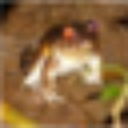

Actual class: frog
61.52% | cat
15.36% | horse
...
00.23681% | ship
00.00601% | automobile



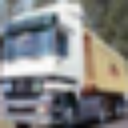

Actual class: truck
98.91% | horse
00.72% | truck
...
00.00000% | deer
00.00000% | automobile



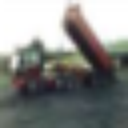

Actual class: truck
98.61% | horse
01.34% | truck
...
00.00000% | deer
00.00000% | automobile



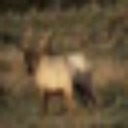

Actual class: deer
33.10% | cat
22.27% | airplane
...
00.18915% | truck
00.00910% | automobile



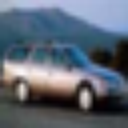

Actual class: automobile
89.33% | horse
07.16% | airplane
...
00.00416% | deer
00.00000% | automobile



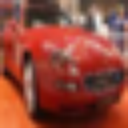

Actual class: automobile
44.25% | cat
22.39% | dog
...
00.04188% | ship
00.00798% | automobile



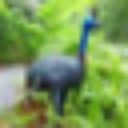

Actual class: bird
92.89% | horse
04.11% | airplane
...
00.00618% | deer
00.00000% | automobile



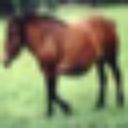

Actual class: horse
82.71% | horse
08.03% | cat
...
00.05635% | ship
00.00003% | automobile



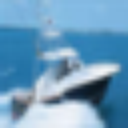

Actual class: ship
99.61% | horse
00.36% | truck
...
00.00000% | deer
00.00000% | automobile



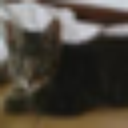

Actual class: cat
38.68% | cat
19.48% | horse
...
00.30511% | ship
00.01508% | automobile



In [ ]:
cifar_test = torchvision.datasets.CIFAR10("~/mlab/datasets/cifar10_train",
                            transform= torchvision.transforms.Compose([
                                torchvision.transforms.PILToTensor(),
                                torchvision.transforms.ConvertImageDtype(torch.float)]),
                            download=True, 
                            train=True)

def eval_cifar(model, num_imgs=10):
    for_display = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((128, 128))])

    cifar_classes = { 0: "airplane",
                      1: "automobile",
                      2: "bird",
                      3: "cat",
                      4: "deer",
                      5: "dog",
                      6: "frog",
                      7: "horse",
                      8: "ship",
                      9: "truck"
                    }
    model.eval()
    with torch.no_grad():
        for i in range(num_imgs):
            x, y = cifar_test[i]
            outputs = model(x.unsqueeze(0))
            probs = torch.softmax(outputs, -1).flatten()
            sorted_probs, sorted_idxs = probs.sort(descending=True)
            sorted_probs = [p.item() for p in sorted_probs]
            sorted_classes = [cifar_classes[idx.item()] for idx in sorted_idxs]

            small_img = for_display(x.cpu())
            display(small_img)
            print(f"Actual class: {cifar_classes[y]}")
            k = 2
            print(
            *(f'{100*prob:05.2f}% | {label}' for prob, label in zip(sorted_probs[:k], sorted_classes[:k])),
            '...',
            *(f'{100*prob:08.5f}% | {label}' for prob, label in zip(sorted_probs[-k:], sorted_classes[-k:])),
            sep='\n',
            end='\n\n',
            )

eval_cifar(jank_cifar)

In [ ]:
import math

# Nikola and Warren - TA Chris

## Readings

Introduction to Convolutions: https://www.youtube.com/watch?v=8rrHTtUzyZA

Residual Networks: https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035

The goal of this project is to familiarize ourselves with the fundamentals of deep learning engineering for computer vision and image recognition. We will reimplement from scratch a member of the ResNet family of vision models and apply our model to classify images into different categories.

We will start by loading an existing ResNet implementation (pretrained on ImageNet), and seeing what sorts of classificaton the model can output. Then, we will discuss and implement the basic blocks of computer vision architectures. After that, we will move to ResNet, and implement the architecture using our basic blocks. We will then use our model for classifying images.

# Prelude: image classifications from a pretrained ResNet

First, we load a pretrained ResNet model from the PyTorch vision repository.

In [ ]:
from torchvision import models
torchvision_resnet34 = models.resnet34(pretrained=True)
resnet34 = torchvision_resnet34
_ = resnet34.eval()

We will download images from the internet to feed into the model.

In [ ]:
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display

def load_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

url = "https://www.oregonzoo.org/sites/default/files/styles/article-full/public/animals/H_chimpanzee%20Jackson.jpg"
img = load_image(url)
img

The model expects a batch of images of shape `(num_images, num_channels=3, height, width)`, and outputs the [classfication logits](https://developers.google.com/machine-learning/glossary/#logits), which is of shape `(num_images, num_classes=1000)`.

In [ ]:
import torch
from torchvision import transforms

inputs = transforms.ToTensor()(img).unsqueeze_(0)
print(inputs.shape)
outputs = resnet34(inputs)
outputs = outputs
print(outputs.shape)

We load the ImageNet class [labels](https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt).

In [ ]:
imagenet_labels_url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
response = requests.get(imagenet_labels_url)
imagenet_labels = eval(response.text)

We select a few random images from the internet, and check the classification results from the model, by looking at the most likely and least likely predicted classes.

In [ ]:
urls = [
    "https://www.oregonzoo.org/sites/default/files/styles/article-full/public/animals/H_chimpanzee%20Jackson.jpg",
    "https://anipassion.com/ow_userfiles/plugins/animal/breed_image_56efffab3e169.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/f2/Platypus.jpg",
    "https://static5.depositphotos.com/1017950/406/i/600/depositphotos_4061551-stock-photo-hourglass.jpg",
    "https://img.nealis.fr/ptv/img/p/g/1465/1464424.jpg",
    "http://www.tudobembresil.com/wp-content/uploads/2015/11/nouvelancopacabana.jpg",
    "https://ychef.files.bbci.co.uk/976x549/p0639ffn.jpg",
    "https://www.thoughtco.com/thmb/Dk3bE4x1qKqrF6LBf2qzZM__LXE=/1333x1000/smart/filters:no_upscale()/iguana2-b554e81fc1834989a715b69d1eb18695.jpg",
    "https://i.redd.it/mbc00vg3kdr61.jpg",
    "https://static.wikia.nocookie.net/disneyfanon/images/a/af/Goofy_pulling_his_ears.jpg",
]

def show_classes_probabilities(urls, model, k=3):
    for url in urls:
        img = load_image(url)
        model.eval()

        inputs = transforms.ToTensor()(img).unsqueeze_(0)
        outputs = model(inputs)
        probs = torch.softmax(outputs, -1).flatten()
        sorted_probs, sorted_idxs = probs.sort(descending=True)
        sorted_probs = [p.item() for p in sorted_probs]
        sorted_classes = [imagenet_labels[idx.item()] for idx in sorted_idxs]

        small_img = img.copy()
        small_img.thumbnail((150, 150))
        display(small_img)
        print(
            *(f'{100*prob:05.2f}% | {label}' for prob, label in zip(sorted_probs[:k], sorted_classes[:k])),
            '...',
            *(f'{100*prob:08.5f}% | {label}' for prob, label in zip(sorted_probs[-k:], sorted_classes[-k:])),
            sep='\n',
            end='\n\n',
        )

show_classes_probabilities(urls, torchvision_resnet34)

### Step: adding images

Now it's your turn! Add a few urls below, and check what their classifications are.

In [ ]:
my_urls = [
    "https://m.media-amazon.com/images/I/61D0QLJU-hL._AC_SL1100_.jpg"
]

show_classes_probabilities(my_urls, torchvision_resnet34)

# Implementing ResNet building blocks

We now start implementing our own ResNet model.

## Operating on tensors: as_strided and einsum

To implement some of our building blocks, we will use the following functions:
* `torch.einsum`: implements summations over tensor indices using Einstein notation. You can read more about it here:
    * https://pytorch.org/docs/stable/generated/torch.einsum.html
    * https://ajcr.net/Basic-guide-to-einsum/
* `torch.as_strided`: PyTorch tensors data are physically stored as 1-d arrays, and the shape and stride abstractions describe a multidimensional indexing API into this data. The shape (or size) is an N-tuple describing the number of valid indices for each dimension. The stride is an N-tuple corersponding to how many cells to jump in the 1-d physical array when the index of each dimension is incremented. The function `.as_strided` can then be used to change the shape and stride of a tensor without changing the underlying data. This can be used to efficiently implement many operations on tensors. You can read more about it here:
    * https://pytorch.org/docs/stable/generated/torch.as_strided.html
    * https://jott.live/markdown/as_strided
    
We will start this section by familiarizing ourselves with these functions by reimplementing some matrix operations.

### Step: as_strided arguments

For each test case below, change the arguments `size` and `stride`, so that a call of `torch.as_strided(test_input_a, size=size, stride=stride)` matches the desired output.

In [ ]:
from collections import namedtuple

test_input_a = torch.tensor([[ 0,  1,  2,  3,  4],
                             [ 5,  6,  7,  8,  9],
                             [10, 11, 12, 13, 14],
                             [15, 16, 17, 18, 19]])

TestCase = namedtuple('TestCase', ['output', 'size', 'stride'])

test_cases = [
  TestCase(
    output=torch.tensor([0, 1, 2, 3]),
    size=(4,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[0, 1, 2],
                         [5, 6, 7]]),
    size=(2,3),
    stride=(5,1),
  ),
  TestCase(
    output=torch.tensor([[0, 0, 0],
                         [11, 11, 11]]),
    size=(2,3),
    stride=(11,0),
  ),
  TestCase(
    output=torch.tensor([0, 6, 12, 18]),
    size=(4,),
    stride=(6,),
  ),
  TestCase(
    output=torch.tensor([[[0, 1, 2],
                          [9, 10, 11]]]),
    size=(1,2,3),
    stride=(1,9,1),
  ),
  TestCase(
    output=torch.tensor([[[[0, 1],
                           [2, 3]],
                          [[4, 5],
                           [6, 7]]],
                         [[[12, 13],
                           [14, 15]],
                          [[16, 17],
                           [18, 19]]]]),
    size=(2,2,2,2),
    stride=(12,4,2,1),
  ),
]

In [ ]:
def is_equal_test(*, output, expected, test_name='Test'):
    successful = torch.allclose(expected.to(float), output.to(float))
    if successful:
        print(f'{test_name} passed!')
    else:
        print(f'{test_name} failed')
        print(f'Output:\n{output}')
        print(f'Expected:\n{expected}')

for i, (expected, size, stride) in enumerate(test_cases):
    output = torch.as_strided(test_input_a, size=size, stride=stride)
    is_equal_test(test_name=i, output=output, expected=expected)

### Step: as_strided trace

Implement a function that receives a square matrix (as a 2d tensor) and returns its [trace](https://en.wikipedia.org/wiki/Trace_(linear_algebra)) using `torch.as_strided` and `torch.sum`



In [ ]:
def strided_trace(a):
    return torch.sum(torch.as_strided(a, size = (a.size(dim=0),), stride = (1+a.size(dim=0),)))

In [ ]:
def einsum_trace(a):
    return torch.einsum('ii->', a)

a = torch.randn(10, 10)
assert torch.allclose(strided_trace(a), einsum_trace(a), rtol=1e-4, atol=1e-4)

### Step: as_strided matmul

Implement a function that receives two matrices (as 2d tensors) and returns their [multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication), using `torch.as_strided`, `torch.sum`, and elementwise multiplication.

In [ ]:
def strided_matmul(a, b):
    n = a.size(dim=0)
    m = a.size(dim=1)
    assert m == b.size(dim=0)
    o = b.size(dim=1)
    
    print(a.size())
    
    a = torch.as_strided(a, size = (n,m,o), stride= (m,1,0))
    b = torch.as_strided(b, size = (n,m,o), stride= (0,o,1))
    
    return torch.sum(a * b, dim = 1)
    
    

In [ ]:
def einsum_matmul(a, b):
    return torch.einsum('ik,kj->ij', a, b)

a = torch.randn(10, 5)
b = torch.randn(5, 15)
assert torch.allclose(strided_matmul(a, b), einsum_matmul(a, b), rtol=1e-4, atol=1e-4)

## Convolutions and pooling

Convolutions are one of the fundamental operations of signal processing. It can be interpreted as a sliding window (a "weight") that goes over all positions of the input and outputs a weighted sum of the values of the region (i.e. the dot product of the weight and the region). Watch this 30-second video: https://www.youtube.com/watch?v=ulKbLD6BRJA

We're going to begin by implementing 1d convolutions without "padding" (when the weight sticks off one side of the input). This means, unlike in the video, the output of the convolution will be a little smaller than the input. See the below image for examples:

<img src=../../.images/1d_conv.jpeg width=800>

We will also implement 2d convolution, in which the weight slides around on the input in 2d, producing one weighted sum in the output for each location it occupies:

<img src=../../.images/2d_conv.png width=800>

A 1-d Convolution can be written as:

$$\operatorname{conv1d}(input, weights)[b, c_o, i] = \sum_{c_i = 0}^{C_i} \sum_{di = 0}^{k-1} weights[c_o, c_i, di] \cdot input[b, c_i, i+di]$$

A 2-d Convolution can be written as:
$$\operatorname{conv2d}(input, weights)[b, c_o, i, j] = \sum_{c_i = 0}^{C_i} \sum_{di = 0}^{k_h-1}\sum_{dj = 0}^{k_w-1} weights[c_o, c_i, di, dj] \cdot input[b, c_i, i+di, j+dj]$$


Clarification on notation: the brackets on the LHS are indices into the output of the function, which (as you can see from the number of indices) is a rank-4 tensor: batch size, num of channels, width, height.

One way to think about convolutions is that convolutions are the linear translation invariant functions. That is, if F is a function, and the following holds:
* $F(x + y) = F(x) + F(y)$
* $F(T(x)) = T(F(x))$ (where $T$ corresponds to shifting the input)

Then $F$ can be written as a convolution.

### Step: conv1d arguments

To get familiarity with `conv1d`, replace the indicated variables to pass the tests below.

In [ ]:
from torch.nn.functional import conv1d as torch_conv1d
from torch.nn.functional import conv2d as torch_conv2d

Replace `weights` to pass the test.

In [ ]:
input = torch.tensor([[[1, 2, 3, 4]]])
weights = torch.tensor([[[1, 3]]])
output = torch_conv1d(input, weights)
expected = torch.tensor([7.0, 11.0, 15.0])
is_equal_test(output=output, expected=expected)

Replace `input` to pass the test.

In [ ]:
input = torch.tensor([[[98, 12, -7, -3, -1, -1, 1, 1]]])
weights = torch.tensor([[[2, 0, -2]]])
output = torch_conv1d(input, weights)
expected = torch.tensor([[[210, 30, -12, -4, -4, -4]]])
is_equal_test(output=output, expected=expected)

Replace `weights` to pass the test.

In [ ]:
input = torch.tensor([[[1, 2, 3],
                       [4, 5, 6]],
                      [[1, 1, 1],
                       [2, 3, 2]]])
weights = torch.tensor([[[1], [2]]]) 
output = torch_conv1d(input, weights)
expected = torch.tensor([[[9, 12, 15]],
                         [[5, 7, 5]]])
is_equal_test(output=output, expected=expected)

### Step: conv1d

Implement 1d convolutions using `torch.as_strided` and `torch.einsum`.

In [ ]:
# x : (batchsize, in_channels, seqlen), weights : (out_channels, in_channels, weight_width)

def conv1d_minimal(x, weights):
    b, c, l = x.size()
    o = weights.size(dim=0)
    k = weights.size(dim=-1)
    x = torch.as_strided(x, size=(b, c, k, l-k+1), stride=(c*l,l,1, 1))

    return torch.einsum("b c k l, o c k -> b o l", x, weights)
    # (batchsize, out_channels, seqlen - weight_width + 1)

In [ ]:
def test_conv1d_minimal(my_conv, n_tests=10):
    import numpy as np
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        weight_size = np.random.randint(1, 10)

        x = torch.randn((b, ci, h))
        weights = torch.randn((co, ci, weight_size))

        my_output = my_conv(x, weights)

        torch_output = torch.conv1d(
            x,
            weights,
            stride=1,
            padding=0,
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv1d (minimal) test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...")
            return
        print(f"Test {i} passed!")
    print('All tests passed!')

test_conv1d_minimal(conv1d_minimal)

### Step: conv2d

Implement 2d convolutions (with minimal arguments). Use `torch.as_strided` and `torch.einsum`.

In [ ]:
# x : (batchsize, in_channels, height, width), weights : (out_channels, in_channels, weight_height, weight_width)

def conv2d_minimal(x, weights):
    b, c, h, w = x.size()
    o = weights.size(dim=0)
    k_h = weights.size(dim=-2)
    k_w = weights.size(dim=-1)
    x = torch.as_strided(x, size=(b, c, k_h, k_w, h-k_h+1, w-k_w+1), stride=(c*h*w, h*w, w, 1, w, 1))

    return torch.einsum("b c i j h w, o c i j -> b o h w", x, weights)
    # (batchsize, out_channels, seqlen - weight_width + 1)

In [ ]:
def test_conv2d_minimal(my_conv, n_tests = 10):
    import numpy as np
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        weight_size = tuple(np.random.randint(1, 10, size=(2,)))

        x = torch.randn((b, ci, h, w))
        weights = torch.randn((co, ci, *weight_size))

        my_output = my_conv(
            x,
            weights
        )

        torch_output = torch.conv2d(
            x,
            weights
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv2d test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...,")
            return
        print(f"Test {i} passed!")

    print('All tests passed!')

test_conv2d_minimal(conv2d_minimal)

### Step: stride and padding

Convolutions generally take a few extra arguments, such as:
* `stride`: how many positions to increment in the input for each position increment in the output. Useful for downsampling the input.
* `padding`: pads the input with $p$ zeroes on each side before applying the convolution. Useful for controlling the output size.

Add `stride` and `padding` parameters to your implementations of `conv1d`, `conv2d`.

In [ ]:
# x : (batchsize, in_channels, seq_len), 
# weights : (out_channels, in_channels, weight_width), 
# stride: int
# padding: int
def conv1d(x, weights, stride=1, padding=0):
    b, c, l = x.size()
    o = weights.size(dim=0)
    k = weights.size(dim=-1)
    x_padded = torch.zeros(b,c,l+2*padding)
    x_padded[:,:,padding:-padding] = x
    x_padded = torch.as_strided(x_padded, size=(b, c, k, math.ceil((l-k+1+2*padding)/stride)), stride=(c*(l+2*padding),l+2*padding,1, stride))

    return torch.einsum("b c k l, o c k -> b o l", x_padded, weights)

# x : (batchsize, in_channels, height, width), 
# weights : (out_channels, in_channels, weight_height, weight_width), 
# stride: int or tuple(int, int)
# padding: int or tuple(int, int)
def conv2d(x, weights, stride=1, padding=0):
    b, c, h, w = x.size()
    o = weights.size(dim=0)
    k_h = weights.size(dim=-2)
    k_w = weights.size(dim=-1)
    if type(padding) == int:
        padding = (padding, padding)
    if type(stride)==int:
        stride=(stride,stride)
    p_h, p_w = padding
    s_h, s_w = stride
    x_padded = torch.zeros(b,c,h+2*p_h, w+2*p_w)
    x_padded[:,:,p_h:-p_h,p_w:-p_w] = x
    h_padded = h + 2*p_h
    w_padded = w + 2*p_w
    x_padded = torch.as_strided(x_padded, 
        size=(b, c, k_h, k_w, math.ceil((h_padded-k_h+1)/s_h), math.ceil((w_padded-k_w+1)/s_w)), 
        stride=(c*h_padded*w_padded, h_padded*w_padded, w_padded, 1, w_padded*s_h, s_w)
    )

    return torch.einsum("b c i j h w, o c i j -> b o h w", x_padded, weights)

In [ ]:
#@title conv2d fuzz tests { form-width:"200px" }


def test_conv1d(my_conv, n_tests = 10):
    import numpy as np

    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        stride = np.random.randint(1, 5)
        padding = np.random.randint(1, 5)
        weight_size = np.random.randint(1, 10)

        x = torch.randn((b, ci, h))
        weights = torch.randn((co, ci, weight_size))

        my_output = my_conv(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        torch_output = torch.conv1d(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv1d test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...")
            return
        print(f"Test {i} passed!")
    print('All tests passed!')

test_conv1d(conv1d)

def test_conv2d(my_conv, n_tests = 10):
    import numpy as np
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)

        stride = tuple(np.random.randint(1, 5, size=(2,)))
        padding = tuple(np.random.randint(1, 5, size=(2,)))
        weight_size = tuple(np.random.randint(1, 10, size=(2,)))

        x = torch.randn((b, ci, h, w))
        weights = torch.randn((co, ci, *weight_size))
        bias = torch.randn((co,))

        my_output = my_conv(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        torch_output = torch.conv2d(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv2d test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...,")
            return
        print(f"Test {i} passed!")

    print('All tests passed!')

test_conv2d(conv2d)



### Step: maxpool2d

Poolings have the same format as convolutions - only that instead of outputting a weighted sum, max poolings output the maximum value of the window, and average poolings output the average.

Implement 2d max pooling using `torch.as_strided` and `torch.amax`.


In [ ]:
# x : (batchsize, in_channels, height, width), 
# weight_size : int or tuple(int, int)
# stride: None or int or tuple(int, int) (assume stride=weight_size if None)
# padding: int or tuple(int, int)

def maxpool2d(x, weight_size, stride=None, padding=0):
    b, c, h, w = x.size()
    
    if type(padding) == int:
        padding = (padding, padding)
    if stride is None:
        stride = weight_size
    if type(stride)==int:
        stride=(stride,stride)
    if type(weight_size) == int:
        weight_size = (weight_size, weight_size)
        
    p_h, p_w = padding
    s_h, s_w = stride
    k_h, k_w = weight_size
    #print(weight_size)
    h_padded = h + 2*p_h
    w_padded = w + 2*p_w
    
    x_padded = torch.ones(b,c,h+2*p_h, w+2*p_w) * (-torch.inf)
    #print(x_padded.size(), x.size(), padding)
    x_padded[:,:,p_h:h_padded-p_h,p_w:w_padded-p_w] = x
    x_padded = torch.as_strided(x_padded, 
        size=(b, c, k_h, k_w, math.ceil((h_padded-k_h+1)/s_h), math.ceil((w_padded-k_w+1)/s_w)), 
        stride=(c*h_padded*w_padded, h_padded*w_padded, w_padded, 1, w_padded*s_h, s_w)
    )
    #print(x_padded.size())
    #print(weight_size)
    ret = torch.amax(x_padded, dim=(2, 3))
    #print(f'size: {x.size()}, weight: {weight_size}, stride: {stride}, pad: {padding}')
    #print(ret.size())
    #print()
    return ret


In [ ]:
#@title maxpool2d fuzz tests { form-width: "200px" }

from torch.nn.functional import max_pool2d as torch_maxpool2d

# Fuzz test
def test_maxpool(my_maxpool2d, n_tests = 100):
    import numpy as np
    
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)

        none_stride = bool(np.random.randint(2))
        if none_stride:
            stride = None
        else:
            stride = tuple(np.random.randint(1, 5, size=(2,)))
        weight_size = tuple(np.random.randint(1, 10, size=(2,)))
        kH, kW = weight_size
        padding = np.random.randint(0, 1 + kH//2), np.random.randint(0, 1 + kW//2)

        x = torch.randn((b, ci, h, w))

        my_output = my_maxpool2d(
            x,
            weight_size,
            stride=stride,
            padding=padding,
        )

        torch_output = torch_maxpool2d(
            x,
            weight_size,
            stride=stride,
            padding=padding,
        )
        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print('A test failed!')
            '''
            print('input:')
            print(x)
            print('----------')
            print('output:')
            print(my_output)
            print('expected:')
            print('----------')
            print(torch_output)
            '''
            #print("bools")
            #print(my_output == torch_output)
            return
        else:
            print("test " + str(i))

    print('All tests passed!')

test_maxpool(maxpool2d)


### Step: Conv2d, MaxPool2d Modules

Implement now Conv2d and MaxPool2d classes, each inheriting `nn.Module`. When you inherit `nn.Module`, your class should define:

- `__init__()`: the constructor. At the start of your constructor, remember to call the constructor of `nn.Module` with `super().__init__()`.
- `forward()`: when your module as invoked as if it were a function with the expression `module(x)`, this results in a call to `module.forward(x)`.  

If you need more info, read our doc on `nn.Module` subclasses [here](https://docs.google.com/document/d/1PYW_lW_-jXpN394S8LtPqivSB91HjAwQi6_iDtmpwXg/edit?usp=sharing)

Crucially, your conv weight should be wrapped in a `torch.nn.Parameter()`. When a `torch.nn.Parameter()` is assigned as an attribute of a `nn.Module`, it will get automatically registered as a learnable parameter, meaning that `model.parameters()` will include it. Additionally, by default `Parameters` keep track of their gradients, while `Tensors` by default do not.

For initializing the values of the Conv2d parameters, read [this](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79)

Do Kaiming initialization, as described in the above. The fan-in should be the number of incoming connections that a specific neuron in the conv layer has: `in_channels * weight_width * weight_height`

In [ ]:
from torch.nn import Module, Parameter

class Conv2d(Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        weight_size,
        stride=1,
        padding=0,
    ):
        super().__init__()
        if type(weight_size)==int:
            weight_size = (weight_size, weight_size)
        fan_in = in_channels * weight_size[0]*weight_size[1]
        self.weight = nn.Parameter(torch.randn(out_channels, weight_size[0], weight_size[1]) * math.sqrt(2/fan_in))
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        return conv2d(x, self.weight, self.stride, self.padding)
        

class MaxPool2d(Module):
    def __init__(
        self,
        weight_size,
        stride=None,
        padding=1,
    ):
        super().__init__()
        self.weight_size = weight_size
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        return maxpool2d(x, self.weight_size, self.stride, self.padding)


## Batch Normalization

One intuition for batch norm is that we don't want the "units"/scale of our input features to matter, because this might distort how they get optimized relative to each other. Thus we would like to make each input feature have mean 0 and variance 1 across the population. To approximate this, we normalize each feature within its batch. We also keep a running mean/variance estimation during training that we use during testing (for more accuracy than the batch stats).

In practice, we normalize entire channels at once, rather than single pixels. This means normalizing each pixel by the mean/variance of all the pixels within that channel, across height, width, and batch.

Read more about batch normalization [here](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739), and look at the diagrams of batchnorm during training/inference for more specifics, which you'll need for your implementation.

Documentation for batchnorm: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html

### Step: BatchNorm2d

Implement a BatchNorm2d module.

In [ ]:
class BatchNorm2d(Module):
    def __init__(
        self,
        num_features,
        eps=1e-5,
        momentum=0.1,
    ):
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.running_mean = None
        self.running_var = None

    def forward(self, x):
        # x is a Tensor, shape=(batchsize, num_features,)
        mean = torch.mean(x, dim=0)
        var = torch.var(x, dim=0)
        if self.running_mean is None:
            self.running_mean = mean
            self.running_var = var
        else:
            self.running_mean = self.momentum*self.running_mean + (1-self.momentum)*mean
            self.running_var = self.momentum*self.running_var + (1-self.momentum)*var
        return (x - mean)/torch.sq(variance+eps)

# Assembling your ResNet

The ResNet has many features typical of vision architectures: blocks of conv + batchnorm + relu, a decreasing width/height paired with an increasing number of channels, and a linear layer at the end that produces logits. It set itself apart from other models at the time by incorporating residual blocks, which add the input to the output of the conv/batchnorm before the relu. These improved loss for large models, as it's easier to propagate signals over many layers of identity mapping + noise, than to propagate signals over many layers of noise.


[ResNet paper](https://arxiv.org/abs/1512.03385)


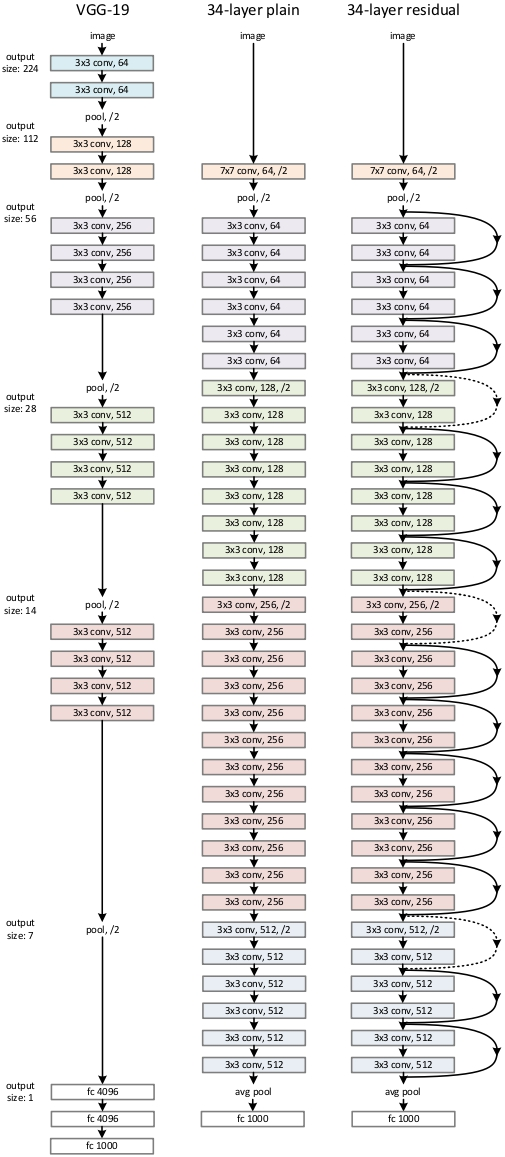

The ResNet architecture can be seen on the right of the figure above. Here is how to interpret it:
* every convolution is followed by a batch norm and a relu;
* "/2" means the height and width are halved (they are kept the same otherwise)
  * the padding is always $p = \frac{k-1}{2}$ (this is known as ["same" padding](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t), because it keeps the same size when the stride is 1)
  * the stride is 2 when there is a "/2", and 1 otherwise
* "$k \times k$ conv, $N$" represents a block of conv+batchnorm+relu, where $k \times k$ is the conv weight size and $N$ is the number of output channels
* side arrows mean that the input is added before the relu at the output
  * bold arrows: output size equals input size, and input is added as is
  * dotted arrows: output height/width is half of the input, and double in features; in this case we downsample the input, passing it through a conv of weight size 1x1 and stride 2;
* the "avg pool" here means a layer with input $(B, C, H, W)$ and output $(B, C, 1)$, where values over height and width dimensions are averaged out into a single value
* the "fc 1000" means a Linear layer with C input features and 1000 output features. Rather than hard-code 1000, we're going to have the number of output classes be a parameter of the model. You'll see that we've made an an argument to the ResNet class's `\_\_init\_\_` method.

Notice that, unlike an MLP, the dimensions of the input image are never hardcoded into this model.

### Step: Residual block

## Start by implementing a residual block (i.e. 2x conv+batchnorm+relu, and a residual connection; the number of input and output channels can vary; whether the output size is the same or is halved can also vary).

In [ ]:
class ReLu(Module):
    def __init__(self):
        super().__init__()
    def forward(x):
        return x.where(x>0,x,0)

def AveragePool(x):
    return torch.mean(x, dim=(2,3))

class Linear(Module):
    def __init__(self, in_feats, out_feats, downsample=False):
        super.__init__()
        self.weights = nn.Parameter(torch.randn(in_feats, out_feats) * math.sqrt(1/in_feats))
        
    def forward(self, x):
        return torch.einsum("...j, jk -> ...k" ,x, weights)

class ResidualBlock(Module):
    def __init__(self, in_feats, out_feats, downsample=False):
        super().__init__()
        if downsample:
            self.stride_1 = 2
            self.down = torch.nn.Sequential(
                Conv2d(self.in_feats,self.out_feats, weight_size= 1,stride=self.stride_1, padding=0),
                BatchNorm2d(out_feats)
            )
        else:
            self.stride_1 = 1
        self.downsample = downsample
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.resblocks = torch.nn.Sequential(
            Conv2d(in_feats, out_feats, stride = self.stride_1, weight_size = (3,3), padding =1),
            BatchNorm2d(out_feats),
            ReLu(),
            Conv2d(out_feats, out_feats, stride = 1, weight_size = (3,3), padding =1),
            BatchNorm2d(out_feats)
        )
        
    def forward(self, x):
        x_new = self.resblocks(x)
        if self.downsample:
            x_new += self.down(x)
        x_new = ReLu(x_new)
        
        return x_new
        

### Step: ResNet34

Implement now the ResNet34 architecture, according to the diagram, using the residual blocks from above.

In [ ]:
class ResNet34(Module):
    def __init__(self, output_size=1000):
        super().__init__()
        self.output_size = output_size
        self.preprocessing = torch.nn.Sequential(
            Conv2d(3, 64, weight_size = 7, stride = 2, padding = 3),
            MaxPool2d(weight_size = 2)
        )
        self.residuals = torch.nn.Sequential(
            # grey
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            # green
            ResidualBlock(64, 128, downsample = True),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            # red
            ResidualBlock(128, 256, downsample = True),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            # blue
            ResidualBlock(256, 512, downsample = True),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512)
        )
        self.linear = Linear(512, self.output_size)
    def forward(self, x):
        x_new = self.preprocessing(x)
        x_new = self.residuals(x_new)
        x_new = AveragePool(x).unsqueeze(2)

        x_new = self.linear(x_new)
        return x_new

Write a function that copies over the weights from the torchvision pretrained resnet34 into yours. The `model.state_dict()` and `model.load_state_dict()` methods will be of use.

In [ ]:
def copy_weights(my_model, torch_model):
    my_model.load_state_dict(torch_model.state_dict()) 

Run the following cell to confirm that your model agrees with the torchvision model at the start.

In [ ]:
copy_weights(resnet34, torchvision_resnet34)

resnet34_backup = resnet34

jank_res = ResNet34()
copy_weights(jank_res, resnet34)
show_classes_probabilities(urls, jank_res)


### Training

### Step: Training your ResNet
That was too easy. Rather than importing someone else's magic parameters, let's actually train our ResNet. We're going to do so for a simpler image-recognition task, the CIFAR10 dataset. This is a dataset of 3x32x32 images that fall into 10 classes, so define a new model that just has 10 outputs. You can mostly follow along with this tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. Make sure your model is in training mode by calling model.train(). 

In [ ]:
import torchvision

cifar_train = torchvision.datasets.CIFAR10("~/mlab/datasets/cifar10_train",
                            transform= torchvision.transforms.Compose([
                                torchvision.transforms.PILToTensor(),
                                torchvision.transforms.ConvertImageDtype(torch.float)]),
                            download=True, 
                            train=True)

### Displaying what your ResNet has learned:

Run the cell below to print some CIFAR images and see how your model labelled them.

In [ ]:
cifar_test = torchvision.datasets.CIFAR10("~/mlab/datasets/cifar10_test",
                            transform= torchvision.transforms.Compose([
                                torchvision.transforms.PILToTensor(),
                                torchvision.transforms.ConvertImageDtype(torch.float)]),
                            download=True, 
                            train=False)

def eval_cifar(model, num_imgs=10):
    for_display = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((128, 128))])

    cifar_classes = { 0: "airplane",
                      1: "automobile",
                      2: "bird",
                      3: "cat",
                      4: "deer",
                      5: "dog",
                      6: "frog",
                      7: "horse",
                      8: "ship",
                      9: "truck"
                    }
    model.eval()
    with torch.no_grad():
        for i in range(num_imgs):
            x, y = cifar_test[i]
            outputs = model(x.unsqueeze(0))
            probs = torch.softmax(outputs, -1).flatten()
            sorted_probs, sorted_idxs = probs.sort(descending=True)
            sorted_probs = [p.item() for p in sorted_probs]
            sorted_classes = [cifar_classes[idx.item()] for idx in sorted_idxs]

            small_img = for_display(x.cpu())
            display(small_img)
            print(f"Actual class: {cifar_classes[y]}")
            k = 2
            print(
            *(f'{100*prob:05.2f}% | {label}' for prob, label in zip(sorted_probs[:k], sorted_classes[:k])),
            '...',
            *(f'{100*prob:08.5f}% | {label}' for prob, label in zip(sorted_probs[-k:], sorted_classes[-k:])),
            sep='\n',
            end='\n\n',
            )

eval_cifar(my_trained_model)

In [ ]:
import math

In [ ]:
import itertools

## Readings

Introduction to Convolutions: https://www.youtube.com/watch?v=8rrHTtUzyZA

Residual Networks: https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035

The goal of this project is to familiarize ourselves with the fundamentals of deep learning engineering for computer vision and image recognition. We will reimplement from scratch a member of the ResNet family of vision models and apply our model to classify images into different categories.

We will start by loading an existing ResNet implementation (pretrained on ImageNet), and seeing what sorts of classificaton the model can output. Then, we will discuss and implement the basic blocks of computer vision architectures. After that, we will move to ResNet, and implement the architecture using our basic blocks. We will then use our model for classifying images.

# Prelude: image classifications from a pretrained ResNet

First, we load a pretrained ResNet model from the PyTorch vision repository.

In [ ]:
from torchvision import models
torchvision_resnet34 = models.resnet34(pretrained=True)
resnet34 = torchvision_resnet34
_ = resnet34.eval()

We will download images from the internet to feed into the model.

In [ ]:
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display

def load_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

url = "https://www.oregonzoo.org/sites/default/files/styles/article-full/public/animals/H_chimpanzee%20Jackson.jpg"
img = load_image(url)
img

The model expects a batch of images of shape `(num_images, num_channels=3, height, width)`, and outputs the [classfication logits](https://developers.google.com/machine-learning/glossary/#logits), which is of shape `(num_images, num_classes=1000)`.

In [ ]:
import torch
from torchvision import transforms

inputs = transforms.ToTensor()(img).unsqueeze_(0)
print(inputs.shape)
outputs = resnet34(inputs)
outputs = outputs
print(outputs.shape)

We load the ImageNet class [labels](https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt).

In [ ]:
imagenet_labels_url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
response = requests.get(imagenet_labels_url)
imagenet_labels = eval(response.text)

We select a few random images from the internet, and check the classification results from the model, by looking at the most likely and least likely predicted classes.

In [ ]:
urls = [
    "https://www.oregonzoo.org/sites/default/files/styles/article-full/public/animals/H_chimpanzee%20Jackson.jpg",
    "https://anipassion.com/ow_userfiles/plugins/animal/breed_image_56efffab3e169.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/f2/Platypus.jpg",
    "https://static5.depositphotos.com/1017950/406/i/600/depositphotos_4061551-stock-photo-hourglass.jpg",
    "https://img.nealis.fr/ptv/img/p/g/1465/1464424.jpg",
    "http://www.tudobembresil.com/wp-content/uploads/2015/11/nouvelancopacabana.jpg",
    "https://ychef.files.bbci.co.uk/976x549/p0639ffn.jpg",
    "https://www.thoughtco.com/thmb/Dk3bE4x1qKqrF6LBf2qzZM__LXE=/1333x1000/smart/filters:no_upscale()/iguana2-b554e81fc1834989a715b69d1eb18695.jpg",
    "https://i.redd.it/mbc00vg3kdr61.jpg",
    "https://static.wikia.nocookie.net/disneyfanon/images/a/af/Goofy_pulling_his_ears.jpg",
]

def show_classes_probabilities(urls, model, k=3):
    for url in urls:
        img = load_image(url)
        model.eval()

        inputs = transforms.ToTensor()(img).unsqueeze_(0)
        outputs = model(inputs)
        probs = torch.softmax(outputs, -1).flatten()
        sorted_probs, sorted_idxs = probs.sort(descending=True)
        sorted_probs = [p.item() for p in sorted_probs]
        sorted_classes = [imagenet_labels[idx.item()] for idx in sorted_idxs]

        small_img = img.copy()
        small_img.thumbnail((150, 150))
        display(small_img)
        print(
            *(f'{100*prob:05.2f}% | {label}' for prob, label in zip(sorted_probs[:k], sorted_classes[:k])),
            '...',
            *(f'{100*prob:08.5f}% | {label}' for prob, label in zip(sorted_probs[-k:], sorted_classes[-k:])),
            sep='\n',
            end='\n\n',
        )

show_classes_probabilities(urls, torchvision_resnet34)

### Step: adding images

Now it's your turn! Add a few urls below, and check what their classifications are.

In [ ]:
my_urls = [
]

show_classes_probabilities(my_urls, torchvision_resnet34)

# Implementing ResNet building blocks

We now start implementing our own ResNet model.

## Operating on tensors: as_strided and einsum

To implement some of our building blocks, we will use the following functions:
* `torch.einsum`: implements summations over tensor indices using Einstein notation. You can read more about it here:
    * https://pytorch.org/docs/stable/generated/torch.einsum.html
    * https://ajcr.net/Basic-guide-to-einsum/
* `torch.as_strided`: PyTorch tensors data are physically stored as 1-d arrays, and the shape and stride abstractions describe a multidimensional indexing API into this data. The shape (or size) is an N-tuple describing the number of valid indices for each dimension. The stride is an N-tuple corersponding to how many cells to jump in the 1-d physical array when the index of each dimension is incremented. The function `.as_strided` can then be used to change the shape and stride of a tensor without changing the underlying data. This can be used to efficiently implement many operations on tensors. You can read more about it here:
    * https://pytorch.org/docs/stable/generated/torch.as_strided.html
    * https://jott.live/markdown/as_strided
    
We will start this section by familiarizing ourselves with these functions by reimplementing some matrix operations.

### Step: as_strided arguments

For each test case below, change the arguments `size` and `stride`, so that a call of `torch.as_strided(test_input_a, size=size, stride=stride)` matches the desired output.

In [ ]:
from collections import namedtuple

test_input_a = torch.tensor([[ 0,  1,  2,  3,  4],
                             [ 5,  6,  7,  8,  9],
                             [10, 11, 12, 13, 14],
                             [15, 16, 17, 18, 19]])

TestCase = namedtuple('TestCase', ['output', 'size', 'stride'])

test_cases = [
  TestCase(
    output=torch.tensor([0, 1, 2, 3]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[0, 1, 2],
                         [5, 6, 7]]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[0, 0, 0],
                         [11, 11, 11]]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([0, 6, 12, 18]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[[0, 1, 2],
                          [9, 10, 11]]]),
    size=(1,),
    stride=(1,),
  ),
  TestCase(
    output=torch.tensor([[[[0, 1],
                           [2, 3]],
                          [[4, 5],
                           [6, 7]]],
                         [[[12, 13],
                           [14, 15]],
                          [[16, 17],
                           [18, 19]]]]),
    size=(1,),
    stride=(1,),
  ),
]

In [ ]:
def is_equal_test(*, output, expected, test_name='Test'):
    successful = torch.allclose(expected.to(float), output.to(float))
    if successful:
        print(f'{test_name} passed!')
    else:
        print(f'{test_name} failed')
        print(f'Output:\n{output}')
        print(f'Expected:\n{expected}')

for i, (expected, size, stride) in enumerate(test_cases):
    output = torch.as_strided(test_input_a, size=size, stride=stride)
    is_equal_test(test_name=i, output=output, expected=expected)

### Step: as_strided trace

Implement a function that receives a square matrix (as a 2d tensor) and returns its [trace](https://en.wikipedia.org/wiki/Trace_(linear_algebra)) using `torch.as_strided` and `torch.sum`



In [ ]:
def strided_trace(a):
    pass

In [ ]:
def einsum_trace(a):
    return torch.einsum('ii->', a)

a = torch.randn(10, 10)
assert torch.allclose(strided_trace(a), einsum_trace(a), rtol=1e-4, atol=1e-4)

### Step: as_strided matmul

Implement a function that receives two matrices (as 2d tensors) and returns their [multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication), using `torch.as_strided`, `torch.sum`, and elementwise multiplication.

In [ ]:
def strided_matmul(a, b):
    pass

In [ ]:
def einsum_matmul(a, b):
    return torch.einsum('ik,kj->ij', a, b)

a = torch.randn(10, 5)
b = torch.randn(5, 15)
assert torch.allclose(strided_matmul(a, b), einsum_matmul(a, b), rtol=1e-4, atol=1e-4)

## Convolutions and pooling

Convolutions are one of the fundamental operations of signal processing. It can be interpreted as a sliding window (a "kernel") that goes over all positions of the input and outputs a weighted sum of the values of the region (i.e. the dot product of the kernel and the region). Watch this 30-second video: https://www.youtube.com/watch?v=ulKbLD6BRJA

We're going to begin by implementing 1d convolutions without "padding" (when the kernel sticks off one side of the input). This means, unlike in the video, the output of the convolution will be a little smaller than the input. See the below image for examples:

<img src=../../.images/1d_conv.jpeg width=800>

We will also implement 2d convolution, in which the kernel slides around on the input in 2d, producing one weighted sum in the output for each location it occupies:

<img src=../../.images/2d_conv.png width=800>

A 1-d Convolution can be written as:

$$\operatorname{conv1d}(input, weights)[b, c_o, i] = \sum_{c_i = 0}^{C_i} \sum_{di = 0}^{k-1} weights[c_o, c_i, di] \cdot input[b, c_i, i+di]$$

A 2-d Convolution can be written as:
$$\operatorname{conv2d}(input, weights)[b, c_o, i, j] = \sum_{c_i = 0}^{C_i} \sum_{di = 0}^{k_h-1}\sum_{dj = 0}^{k_w-1} weights[c_o, c_i, di, dj] \cdot input[b, c_i, i+di, j+dj]$$


Clarification on notation: the brackets on the LHS are indices into the output of the function, which (as you can see from the number of indices) is a rank-4 tensor: batch size, num of channels, width, height.

One way to think about convolutions is that convolutions are the linear translation invariant functions. That is, if F is a function, and the following holds:
* $F(x + y) = F(x) + F(y)$
* $F(T(x)) = T(F(x))$ (where $T$ corresponds to shifting the input)

Then $F$ can be written as a convolution.

### Step: conv1d arguments

To get familiarity with `conv1d`, replace the indicated variables to pass the tests below.

In [ ]:
from torch.nn.functional import conv1d as torch_conv1d
from torch.nn.functional import conv2d as torch_conv2d

Replace `weights` to pass the test.

In [ ]:
input = torch.tensor([[[1, 2, 3, 4]]])
weights = torch.tensor([[[0, 0]]])
output = torch_conv1d(input, weights)
expected = torch.tensor([7.0, 11.0, 15.0])
is_equal_test(output=output, expected=expected)

Replace `input` to pass the test.

In [ ]:
input = torch.tensor([[[1, 1, 1, 1, 1, 1, 1, 1]]])
weights = torch.tensor([[[2, 0, -2]]])
output = torch_conv1d(input, weights)
expected = torch.tensor([[[210, 30, -12, -4, -4, -4]]])
is_equal_test(output=output, expected=expected)

Replace `weights` to pass the test.

In [ ]:
input = torch.tensor([[[1, 2, 3],
                       [4, 5, 6]],
                      [[1, 1, 1],
                       [2, 3, 2]]])
weights = torch.tensor([[[0], [0]]]) 
output = torch_conv1d(input, weights)
expected = torch.tensor([[[9, 12, 15]],
                         [[5, 7, 5]]])
is_equal_test(output=output, expected=expected)

### Step: conv1d

Implement 1d convolutions using `torch.as_strided` and `torch.einsum`.

In [ ]:
# x : (batchsize, in_channels, seqlen), weights : (out_channels, in_channels, kernel_width)

def conv1d_minimal(x, weights):
    pass

In [ ]:
def test_conv1d_minimal(my_conv, n_tests=10):
    import numpy as np
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        kernel_size = np.random.randint(1, 10)

        x = torch.randn((b, ci, h))
        weights = torch.randn((co, ci, kernel_size))

        my_output = my_conv(x, weights)

        torch_output = torch.conv1d(
            x,
            weights,
            stride=1,
            padding=0,
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv1d (minimal) test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...")
            return
        print(f"Test {i} passed!")
    print('All tests passed!')

test_conv1d_minimal(conv1d_minimal)

### Step: conv2d

Implement 2d convolutions (with minimal arguments). Use `torch.as_strided` and `torch.einsum`.

In [ ]:
# x : (batchsize, in_channels, height, width), weights : (out_channels, in_channels, kernel_height, kernel_width)

def conv2d_minimal(x, weights):
    pass

In [ ]:
def test_conv2d_minimal(my_conv, n_tests = 10):
    import numpy as np
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        kernel_size = tuple(np.random.randint(1, 10, size=(2,)))

        x = torch.randn((b, ci, h, w))
        weights = torch.randn((co, ci, *kernel_size))

        my_output = my_conv(
            x,
            weights
        )

        torch_output = torch.conv2d(
            x,
            weights
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv2d test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...,")
            return
        print(f"Test {i} passed!")

    print('All tests passed!')

test_conv2d_minimal(conv2d_minimal)

### Step: stride and padding

Convolutions generally take a few extra arguments, such as:
* `stride`: how many positions to increment in the input for each position increment in the output. Useful for downsampling the input.
* `padding`: pads the input with $p$ zeroes on each side before applying the convolution. Useful for controlling the output size.

Add `stride` and `padding` parameters to your implementations of `conv1d`, `conv2d`.

In [ ]:
# x : (batchsize, in_channels, seq_len), 
# weights : (out_channels, in_channels, kernel_width), 
# stride: int
# padding: int
def conv1d(x, weights, stride=1, padding=0):
    pass

# x : (batchsize, in_channels, height, width), 
# weights : (out_channels, in_channels, kernel_height, kernel_width), 
# stride: int or tuple(int, int)
# padding: int or tuple(int, int)
def conv2d(x, weights, stride=1, padding=0):
    pass

In [ ]:
#@title conv2d fuzz tests { form-width:"200px" }


def test_conv1d(my_conv, n_tests = 10):
    import numpy as np

    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        stride = np.random.randint(1, 5)
        padding = np.random.randint(0, 5)
        kernel_size = np.random.randint(1, 10)

        x = torch.randn((b, ci, h))
        weights = torch.randn((co, ci, kernel_size))

        my_output = my_conv(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        torch_output = torch.conv1d(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv1d test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...")
            return
        print(f"Test {i} passed!")
    print('All tests passed!')

test_conv1d(conv1d)

def test_conv2d(my_conv, n_tests = 10):
    import numpy as np
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)

        stride = tuple(np.random.randint(1, 5, size=(2,)))
        padding = tuple(np.random.randint(0, 5, size=(2,)))
        kernel_size = tuple(np.random.randint(1, 10, size=(2,)))

        x = torch.randn((b, ci, h, w))
        weights = torch.randn((co, ci, *kernel_size))
        bias = torch.randn((co,))

        my_output = my_conv(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        torch_output = torch.conv2d(
            x,
            weights,
            stride=stride,
            padding=padding
        )

        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print(f'Conv2d test {i} failed.')
            print(f"Expected {torch_output.flatten()[:5]}...,")
            print(f"Got {my_output.flatten()[:5]}...,")
            return
        print(f"Test {i} passed!")

    print('All tests passed!')

test_conv2d(conv2d)



### Step: maxpool2d

Poolings have the same format as convolutions - only that instead of outputting a weighted sum, max poolings output the maximum value of the window, and average poolings output the average.

Implement 2d max pooling using `torch.as_strided` and `torch.amax`.


In [ ]:
# x : (batchsize, in_channels, height, width), 
# kernel_size : int or tuple(int, int)
# stride: None or int or tuple(int, int) (assume stride=kernel_size if None)
# padding: int or tuple(int, int)

def maxpool2d(x, kernel_size, stride=None, padding=0):
    pass

In [ ]:
#@title maxpool2d fuzz tests { form-width: "200px" }

from torch.nn.functional import max_pool2d as torch_maxpool2d

# Fuzz test
def test_maxpool(my_maxpool2d, n_tests = 100):
    import numpy as np
    
    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)

        none_stride = bool(np.random.randint(2))
        if none_stride:
            stride = None
        else:
            stride = tuple(np.random.randint(1, 5, size=(2,)))
        kernel_size = tuple(np.random.randint(1, 10, size=(2,)))
        kH, kW = kernel_size
        padding = np.random.randint(0, 1 + kH//2), np.random.randint(0, 1 + kW//2)

        x = torch.randn((b, ci, h, w))

        my_output = my_maxpool2d(
            x,
            kernel_size,
            stride=stride,
            padding=padding,
        )

        torch_output = torch_maxpool2d(
            x,
            kernel_size,
            stride=stride,
            padding=padding,
        )
        if not torch.allclose(my_output, torch_output, atol=1e-4, rtol=1e-4):
            print('A test failed!')
            print('input:')
            print(x)
            print('----------')
            print('output:')
            print(my_output)
            print('expected:')
            print('----------')
            print(torch_output)
            return

    print('All tests passed!')

test_maxpool(maxpool2d)


### Step: Conv2d, MaxPool2d Modules

Implement now Conv2d and MaxPool2d classes, each inheriting `nn.Module`. When you inherit `nn.Module`, your class should define:

- `__init__()`: the constructor. At the start of your constructor, remember to call the constructor of `nn.Module` with `super().__init__()`.
- `forward()`: when your module as invoked as if it were a function with the expression `module(x)`, this results in a call to `module.forward(x)`.  

If you need more info, read our doc on `nn.Module` subclasses [here](https://docs.google.com/document/d/1PYW_lW_-jXpN394S8LtPqivSB91HjAwQi6_iDtmpwXg/edit?usp=sharing)

Crucially, your conv kernel should be wrapped in a `torch.nn.Parameter()`. When a `torch.nn.Parameter()` is assigned as an attribute of a `nn.Module`, it will get automatically registered as a learnable parameter, meaning that `model.parameters()` will include it. Additionally, by default `Parameters` keep track of their gradients, while `Tensors` by default do not.

For initializing the values of the Conv2d parameters, read [this](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79)

Do Kaiming initialization, as described in the above. The fan-in should be the number of incoming connections that a specific neuron in the conv layer has: `in_channels * kernel_width * kernel_height`

In [ ]:
from torch.nn import Module, Parameter

class Conv2d(Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
    ):
        pass

    def forward(self, x):
        pass
        

class MaxPool2d(Module):
    def __init__(
        self,
        kernel_size,
        stride=None,
        padding=1,
    ):
        pass

    def forward(self, x):
        pass


## Batch Normalization

One intuition for batch norm is that we don't want the "units"/scale of our input features to matter, because this might distort how they get optimized relative to each other. Thus we would like to make each input feature have mean 0 and variance 1 across the population. To approximate this, we normalize each feature within its batch. We also keep a running mean/variance estimation during training that we use during testing (for more accuracy than the batch stats).

In practice, we normalize entire channels at once, rather than single pixels. This means normalizing each pixel by the mean/variance of all the pixels within that channel, across height, width, and batch.

Read more about batch normalization [here](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739), and look at the diagrams of batchnorm during training/inference for more specifics, which you'll need for your implementation.

Documentation for batchnorm: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html

### Step: BatchNorm2d

Implement a BatchNorm2d module.

In [ ]:
class BatchNorm2d(Module):
    def __init__(
        self,
        num_features,
        eps=1e-5,
        momentum=0.1,
    ):
        pass

    def forward(self, x):
        pass

# Assembling your ResNet

The ResNet has many features typical of vision architectures: blocks of conv + batchnorm + relu, a decreasing width/height paired with an increasing number of channels, and a linear layer at the end that produces logits. It set itself apart from other models at the time by incorporating residual blocks, which add the input to the output of the conv/batchnorm before the relu. These improved loss for large models, as it's easier to propagate signals over many layers of identity mapping + noise, than to propagate signals over many layers of noise.


[ResNet paper](https://arxiv.org/abs/1512.03385)


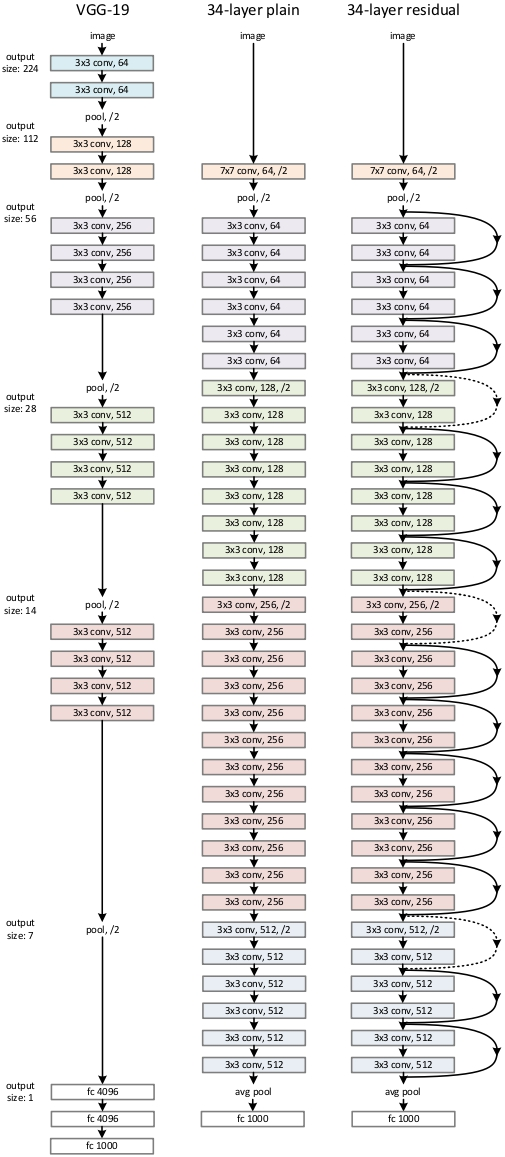

The ResNet architecture can be seen on the right of the figure above. Here is how to interpret it:
* every convolution is followed by a batch norm and a relu;
* "/2" means the height and width are halved (they are kept the same otherwise)
  * the padding is always $p = \frac{k-1}{2}$ (this is known as ["same" padding](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t), because it keeps the same size when the stride is 1)
  * the stride is 2 when there is a "/2", and 1 otherwise
* "$k \times k$ conv, $N$" represents a block of conv+batchnorm+relu, where $k \times k$ is the conv kernel size and $N$ is the number of output channels
* side arrows mean that the input is added before the relu at the output
  * bold arrows: output size equals input size, and input is added as is
  * dotted arrows: output height/width is half of the input, and double in features; in this case we downsample the input, passing it through a conv of kernel size 1x1 and stride 2;
* the "avg pool" here means a layer with input $(B, C, H, W)$ and output $(B, C, 1)$, where values over height and width dimensions are averaged out into a single value
* the "fc 1000" means a Linear layer with C input features and 1000 output features. Rather than hard-code 1000, we're going to have the number of output classes be a parameter of the model. You'll see that we've made an an argument to the ResNet class's `\_\_init\_\_` method.

Notice that, unlike an MLP, the dimensions of the input image are never hardcoded into this model.

### Step: Residual block

Start by implementing a residual block (i.e. 2x conv+batchnorm+relu, and a residual connection; the number of input and output channels can vary; whether the output size is the same or is halved can also vary).

In [ ]:
class ResidualBlock(Module):
    def __init__(self, in_feats, out_feats, downsample=False):
        pass

    def forward(self, x):
        pass

### Step: ResNet34

Implement now the ResNet34 architecture, according to the diagram, using the residual blocks from above.

In [ ]:
class ResNet34(Module):
    def __init__(self, output_size=1000):
        pass
  
    def forward(self, x):
        pass

Write a function that copies over the weights from the torchvision pretrained resnet34 into yours. The `model.state_dict()` and `model.load_state_dict()` methods will be of use.

In [ ]:
def copy_weights(my_model, torch_model):
    pass

Run the following cell to confirm that your model agrees with the torchvision model at the start.

In [ ]:
copy_weights(resnet34, torchvision_resnet34)
show_classes_probabilities(urls, resnet34)

### Training

### Step: Training your ResNet
That was too easy. Rather than importing someone else's magic parameters, let's actually train our ResNet. We're going to do so for a simpler image-recognition task, the CIFAR10 dataset. This is a dataset of 3x32x32 images that fall into 10 classes, so define a new model that just has 10 outputs. You can mostly follow along with this tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. Make sure your model is in training mode by calling model.train(). 

In [ ]:
import torchvision

cifar_train = torchvision.datasets.CIFAR10("~/mlab/datasets/cifar10_train",
                            transform= torchvision.transforms.Compose([
                                torchvision.transforms.PILToTensor(),
                                torchvision.transforms.ConvertImageDtype(torch.float)]),
                            download=True, 
                            train=True)

### Displaying what your ResNet has learned:

Run the cell below to print some CIFAR images and see how your model labelled them.

In [ ]:
cifar_test = torchvision.datasets.CIFAR10("~/mlab/datasets/cifar10_test",
                            transform= torchvision.transforms.Compose([
                                torchvision.transforms.PILToTensor(),
                                torchvision.transforms.ConvertImageDtype(torch.float)]),
                            download=True, 
                            train=False)

def eval_cifar(model, num_imgs=10):
    for_display = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((128, 128))])

    cifar_classes = { 0: "airplane",
                      1: "automobile",
                      2: "bird",
                      3: "cat",
                      4: "deer",
                      5: "dog",
                      6: "frog",
                      7: "horse",
                      8: "ship",
                      9: "truck"
                    }
    model.eval()
    with torch.no_grad():
        for i in range(num_imgs):
            x, y = cifar_test[i]
            outputs = model(x.unsqueeze(0))
            probs = torch.softmax(outputs, -1).flatten()
            sorted_probs, sorted_idxs = probs.sort(descending=True)
            sorted_probs = [p.item() for p in sorted_probs]
            sorted_classes = [cifar_classes[idx.item()] for idx in sorted_idxs]

            small_img = for_display(x.cpu())
            display(small_img)
            print(f"Actual class: {cifar_classes[y]}")
            k = 2
            print(
            *(f'{100*prob:05.2f}% | {label}' for prob, label in zip(sorted_probs[:k], sorted_classes[:k])),
            '...',
            *(f'{100*prob:08.5f}% | {label}' for prob, label in zip(sorted_probs[-k:], sorted_classes[-k:])),
            sep='\n',
            end='\n\n',
            )

eval_cifar(my_trained_model)